In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler

In [3]:
np.random.seed(42)

claims_data = pd.read_csv('ProcessedClaimData.csv')

In [4]:
def identify_columns(claims_data):
    # Identify categorical and numerical columns
    categorical_cols = claims_data.select_dtypes(include=['object', 'string']).columns.tolist()
    numerical_cols = claims_data.select_dtypes(include=['int64', 'float64']).columns.tolist()

    # Remove the target variable from the feature lists
    target_col = 'SettlementValue'

    # Remove both the log-transformed target AND the original settlement value from features
    if target_col in numerical_cols:
        numerical_cols.remove(target_col)

    if 'LogSettlementValue' in numerical_cols:
        numerical_cols.remove('LogSettlementValue')

    print(f"\nCategorical columns: {categorical_cols}")
    print(f"Numerical columns: {numerical_cols}")
    print(f"Target column: {target_col}")

    return categorical_cols, numerical_cols, target_col

# Update categorical and numerical columns based on the transformed dataset
def define_preprocessor(claims_data):
    categorical_cols, numerical_cols, _ = identify_columns(claims_data=claims_data)

    categorical_cols = [col for col in categorical_cols if col in claims_data.columns]
    numerical_cols = [col for col in numerical_cols if col in claims_data.columns]

    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
    ])

    return preprocessor, categorical_cols, numerical_cols

# Function to evaluate a model
def evaluate_model(model, X, y, model_name, log_transform=True):
    y_pred = model.predict(X)
    
    # Calculate metrics on log scale
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    # Calculate metrics on original GBP scale
    if log_transform:
        y_pounds = np.expm1(y)
        y_pred_pounds = np.expm1(y_pred)
        mse_pounds = mean_squared_error(y_pounds, y_pred_pounds)
        rmse_pounds = np.sqrt(mse_pounds)
        mae_pounds = mean_absolute_error(y_pounds, y_pred_pounds)
    else:
        y_pounds = y
        y_pred_pounds = y_pred
        mse_pounds = mse
        rmse_pounds = rmse
        mae_pounds = mae
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R^2': r2,
        'Name': model_name,
        'MSE_GBP': mse_pounds,
        'RMSE_GBP': rmse_pounds,
        'MAE_GBP': mae_pounds,
        'y_pred': y_pred,
        'y_pred_GBP': y_pred_pounds
    }

In [5]:
def find_optimal_gmm_clusters(X, max_clusters=10, random_state=42, plot=True):
    """
    Fits GMM models with 1 to max_clusters and evaluates AIC/BIC to find the optimal number of clusters.
    
    Parameters:
    - X: preprocessed data (numerical + one-hot categorical)
    - max_clusters: max number of clusters to try
    - random_state: for reproducibility
    - plot: whether to show AIC/BIC plots
    
    Returns:
    - best_n_clusters: number of clusters with lowest BIC
    - gmm_models: list of fitted GMMs
    """
    aic_scores = []
    bic_scores = []
    gmm_models = []

    for n in range(1, max_clusters + 1):
        gmm = GaussianMixture(n_components=n, random_state=random_state)
        gmm.fit(X)
        gmm_models.append(gmm)
        aic_scores.append(gmm.aic(X))
        bic_scores.append(gmm.bic(X))

    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, max_clusters + 1), aic_scores, label='AIC', marker='o')
        plt.plot(range(1, max_clusters + 1), bic_scores, label='BIC', marker='o')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Score')
        plt.title('AIC and BIC to Determine Optimal Clusters')
        plt.legend()
        plt.grid(True)
        plt.show()

    # Get number of clusters with lowest BIC
    best_n_clusters = np.argmin(bic_scores) + 1
    return best_n_clusters, gmm_models[np.argmin(bic_scores)]

In [6]:
# Define a custom transformer for predicting clusters and probabilities
class GMMClusterer(BaseEstimator, TransformerMixin):
    def __init__(self, max_clusters=10, random_state=42):
        self.max_clusters = max_clusters
        self.random_state = random_state
        self.gmm = None
        self.best_k = None

    def fit(self, X, y=None):
        # Fit GMM model and determine the best number of clusters
        self.best_k, self.gmm = find_optimal_gmm_clusters(X, max_clusters=self.max_clusters, random_state=self.random_state, plot=False)
        self.n_clusters_ = self.best_k
        return self

    def transform(self, X):
        # Predict the clusters and return the cluster probabilities
        cluster_probs = self.gmm.predict_proba(X)
        return cluster_probs


class ClusterModelTrainer(BaseEstimator, TransformerMixin):
    def __init__(self, models=None, max_clusters=10, random_state=42, cv=5, weight_threshold_percentile=10, normalize_weights=True):
        self.best_models = {}
        self.clusterer = None
        self.cluster_performance = {}
        self.cv = cv
        self.max_clusters = max_clusters
        self.models = models or {
            LinearRegression(),
            Ridge(),
            RandomForestRegressor(random_state=42),
            GradientBoostingRegressor(random_state=42),
        }
        self.n_clusters = None
        self.normalize_weights = normalize_weights
        self.random_state = random_state
        self.weight_threshold_percentile = weight_threshold_percentile

    def fit(self, X, y):
        # Fit GMM and compute soft clusters
        best_n_clusters, self.clusterer = find_optimal_gmm_clusters(X, max_clusters=self.max_clusters, random_state=self.random_state, plot=True)
        print(f"Optimal number of clusters: {best_n_clusters}")
        self.clusterer.fit(X)
        cluster_probs = self.clusterer.predict_proba(X)
        self.n_clusters = best_n_clusters

        cluster_sizes = cluster_probs.sum(axis=0)

        # Train and select best model for each cluster
        for cluster_idx in range(self.n_clusters):
            raw_weights = cluster_probs[:, cluster_idx].copy()

            # Determine dynamic threshold
            threshold = np.percentile(raw_weights, self.weight_threshold_percentile)
            weights = np.where(raw_weights >= threshold, raw_weights, 0)

            # Normalize weights if enabled
            if self.normalize_weights and weights.sum() > 0:
                weights /= weights.sum()
                weights *= len(weights)  # keep mean weight ~1

            if np.count_nonzero(weights) < 2:
                print(f"Cluster {cluster_idx} has too few weighted samples after thresholding.")
                continue

            best_score = -np.inf
            best_model = None

            for model in self.models:
                candidate = clone(model)
                try:
                    scores = cross_val_score(
                        candidate,
                        X,
                        y,
                        cv=self.cv,
                        scoring='neg_mean_absolute_error',
                        fit_params={'sample_weight': weights}
                    )
                except TypeError:
                    # Some models may not support sample_weight in CV - fallback to fitting directly
                    candidate.fit(X, y, sample_weight=weights)
                    scores = [-np.mean((candidate.predict(X) - y) ** 2)]

                mean_score = np.mean(scores)
                if mean_score > best_score:
                    best_score = mean_score
                    best_model = clone(candidate)

            if best_model is None:
                print(f"No valid model found for cluster {cluster_idx}.")
                continue

            print(f"Cluster {cluster_idx}: Best model is {best_model.__class__.__name__} with CV MSE {best_score:.2f}")
            best_model.fit(X, y, sample_weight=weights)
            self.best_models[cluster_idx] = best_model
            self.cluster_performance[cluster_idx] = {
                'model': best_model,
                'cv_mae': -best_score, # scoring = 'neg_mean_absolute_error'
                'size': cluster_sizes[cluster_idx]
            }

        return self

    def predict(self, X):
        if self.clusterer is None or not self.best_models:
            raise ValueError("Model has not been fitted yet.")

        cluster_probs = self.clusterer.predict_proba(X)
        y_preds = np.zeros(X.shape[0])

        for cluster_idx, model in self.best_models.items():
            cluster_pred = model.predict(X)
            y_preds += cluster_pred * cluster_probs[:, cluster_idx]

        return y_preds


class ClusterModelTrainerWithTuning(BaseEstimator, TransformerMixin):
    def __init__(self, models=None, param_grids=None, max_clusters=10, random_state=42, cv=10, weight_threshold_percentile=10, normalize_weights=True):
        self.best_models = {}
        self.clusterer = None
        self.cluster_performance = {}
        self.cv = cv
        self.max_clusters = max_clusters
        self.models = models or {
            'RandomForest': RandomForestRegressor(random_state=42),
            'GradientBoosting': GradientBoostingRegressor(random_state=42),
            'LinearRegression': LinearRegression(),
            'Ridge': Ridge(),
        }
        self.n_clusters = None
        self.normalize_weights = normalize_weights
        self.param_grids = param_grids or {
            'RandomForestRegressor': {
                'n_estimators': [50, 100, 200],
                'max_depth': [None, 10, 20],
                'min_samples_split': [2, 5]
            },
            'GradientBoostingRegressor': {
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.01, 0.1, 0.2],
                'max_depth': [3, 5, 7]
            },
            'LinearRegression': {},
            'Ridge': {
                'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
            }
        }
        self.random_state = random_state
        self.weight_threshold_percentile = weight_threshold_percentile

    def fit(self, X, y):
        best_n_clusters, self.clusterer = find_optimal_gmm_clusters(X, max_clusters=self.max_clusters, random_state=self.random_state, plot=True)
        print(f"Optimal number of clusters: {best_n_clusters}")
        self.clusterer.fit(X)
        cluster_probs = self.clusterer.predict_proba(X)
        self.n_clusters = best_n_clusters

        for cluster_idx in range(self.n_clusters):
            raw_weights = cluster_probs[:, cluster_idx].copy()
            
            # Determine dynamic threshold
            threshold = np.percentile(raw_weights, self.weight_threshold_percentile)
            weights = np.where(raw_weights >= threshold, raw_weights, 0)

            # Normalize weights if enabled
            if self.normalize_weights and weights.sum() > 0:
                weights /= weights.sum()
                weights *= len(weights)  # keep mean weight ~1

            if np.count_nonzero(weights) < 2:
                print(f"Cluster {cluster_idx} has too few weighted samples after thresholding.")
                continue

            best_score = -np.inf
            best_model = None

            for model_name, model in self.models.items():
                candidate = clone(model)
                param_grid = self.param_grids.get(model_name, {})

                grid_search = GridSearchCV(
                    estimator=candidate,
                    param_grid=param_grid,
                    cv=self.cv,
                    scoring='neg_mean_absolute_error',
                    n_jobs=-1,
                    verbose=1,
                    error_score=np.nan
                )
                try:
                    grid_search.fit(X, y, sample_weight=weights)
                    mean_score = grid_search.best_score_
                except ValueError:
                    # Some models may not support sample_weight in CV - fallback to fitting directly
                    candidate.fit(X, y, sample_weight=weights)
                    mean_score = -np.mean((candidate.predict(X) - y) ** 2)

                if mean_score > best_score:
                    best_score = mean_score
                    best_model = grid_search.best_estimator_

            if best_model is None:
                print(f"No valid model found for cluster {cluster_idx}.")
                continue

            print(f"Cluster {cluster_idx}: Best model is {best_model.__class__.__name__} with CV MAE {best_score:.2f}")
            best_model.fit(X, y, sample_weight=weights)
            self.best_models[cluster_idx] = best_model
            self.cluster_performance[cluster_idx] = {
                'model': best_model,
                'cv_mae': -best_score,  # scoring = 'neg_mean_absolute_error'
                'size': cluster_probs[:, cluster_idx].sum()
            }

        return self

    def predict(self, X):
        if self.clusterer is None or not self.best_models:
            raise ValueError("Model has not been fitted yet.")

        cluster_probs = self.clusterer.predict_proba(X)
        y_preds = np.zeros(X.shape[0])

        for cluster_idx, model in self.best_models.items():
            cluster_pred = model.predict(X)
            y_preds += cluster_pred * cluster_probs[:, cluster_idx]

        return y_preds


# Define the full pipeline with clustering and model training
def create_full_pipeline(X, max_clusters=10, trainer_class=ClusterModelTrainer):
    """
    Creates a pipeline with the specified clustering trainer class.

    Args:
        X: Input data for preprocessor definition.
        max_clusters: Maximum number of clusters for GMM.
        trainer_class: Class for the cluster model trainer.
    """
    preprocessor, _, _ = define_preprocessor(X)
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('feature_stack', FeatureStacker([
            ('gmm', GMMClusterer(max_clusters=max_clusters))
        ])),
        ('cluster_model_trainer', trainer_class(max_clusters=max_clusters))
    ])

    return pipeline


class FeatureStacker(BaseEstimator, TransformerMixin):
    def __init__(self, transformers):
        self.transformers = transformers
        self.named_transformers = dict(transformers)

    def fit(self, X, y=None):
        for name, trans in self.transformers:
            trans.fit(X, y)
        return self

    def transform(self, X):
        features = [X]
        for name, trans in self.transformers:
            new_feat = trans.transform(X)
            print(f"FeatureStacker - Transformer '{name}' output shape: {new_feat.shape}")
            features.append(new_feat)
        combined_features = np.hstack(features)
        print(f"FeatureStacker - Combined features shape: {combined_features.shape}")
        return combined_features


Categorical columns: ['AccidentType', 'DominantInjury', 'VehicleType', 'WeatherConditions', 'AccidentDescription', 'InjuryDescription', 'Gender']
Numerical columns: ['InjuryPrognosis', 'SpecialHealthExpenses', 'SpecialReduction', 'SpecialOverage', 'GeneralRest', 'SpecialAdditionalInjury', 'SpecialEarningsLoss', 'SpecialUsageLoss', 'SpecialMedications', 'SpecialAssetDamage', 'SpecialRehabilitation', 'SpecialFixes', 'GeneralFixed', 'GeneralUplift', 'SpecialLoanerVehicle', 'SpecialTripCosts', 'SpecialJourneyExpenses', 'SpecialTherapy', 'ExceptionalCircumstances', 'MinorPsychologicalInjury', 'Whiplash', 'AccidentDate', 'ClaimDate', 'VehicleAge', 'DriverAge', 'NumberOfPassengers', 'PoliceReportFiled', 'WitnessPresent']
Target column: SettlementValue


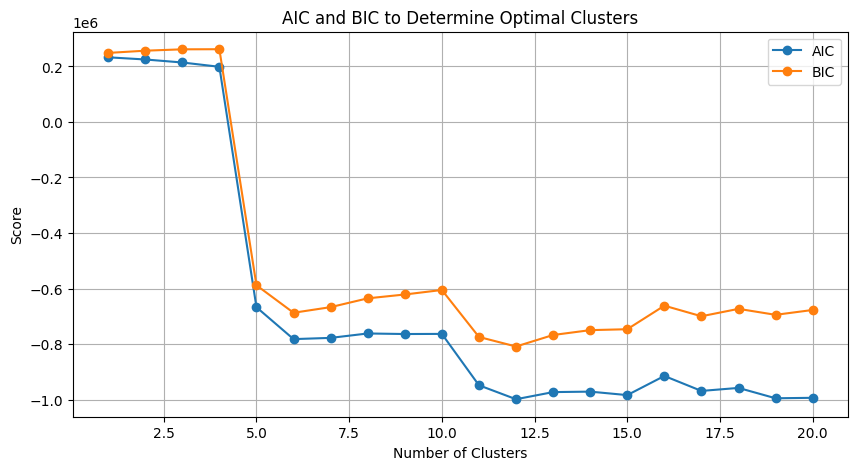


Best number of clusters: 12


In [7]:
preprocessor_temp, _, _ = define_preprocessor(claims_data=claims_data)
X_preprocessed_temp = preprocessor_temp.fit_transform(claims_data.drop(columns=['SettlementValue']))

# Determine the best number of clusters
best_k, best_gmm = find_optimal_gmm_clusters(X_preprocessed_temp, max_clusters=20, plot=True)

print(f"\nBest number of clusters: {best_k}")

In [8]:
top_10_features = [
    'InjuryPrognosis',
    'GeneralRest',
    'SpecialTherapy',
    'SpecialEarningsLoss',
    'SpecialAssetDamage',
    'GeneralFixed',
    'SpecialLoanerVehicle',
    'SpecialJourneyExpenses',
    'SpecialUsageLoss',
    'DaysBetweenAccidentAndClaim'
]

### Model training

GMM clustering used to cluster input data with probabilities of belonging to each cluster.

Different models then trained on each cluster, weighted by the probabilities of each data point belonging to the cluster.

Predictions perform clustering on the data, and each cluster model is predicted on with its output weighted for the overall prediction.


Categorical columns: []
Numerical columns: ['InjuryPrognosis', 'GeneralRest', 'SpecialTherapy', 'SpecialEarningsLoss', 'SpecialAssetDamage', 'GeneralFixed', 'SpecialLoanerVehicle', 'SpecialJourneyExpenses', 'SpecialUsageLoss', 'DaysBetweenAccidentAndClaim']
Target column: SettlementValue
FeatureStacker - Transformer 'gmm' output shape: (3437, 9)
FeatureStacker - Combined features shape: (3437, 19)


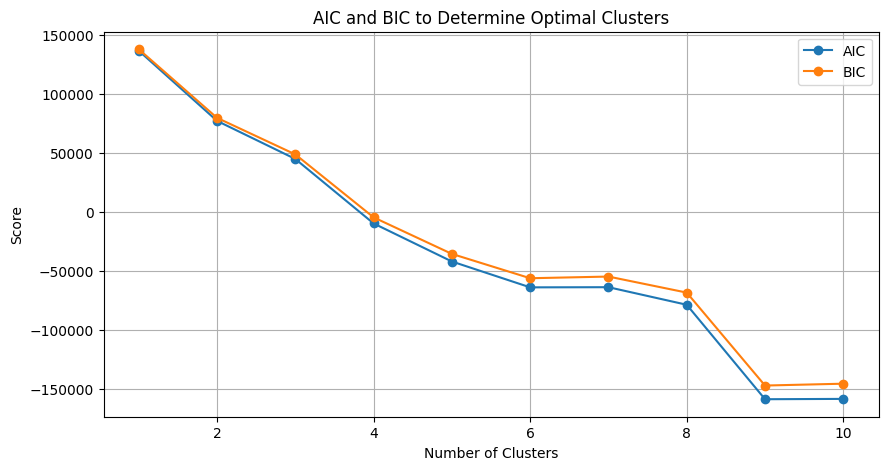

Optimal number of clusters: 9
Cluster 0: Best model is RandomForestRegressor with CV MSE -0.06
Cluster 1: Best model is LinearRegression with CV MSE -3.31
Cluster 2: Best model is Ridge with CV MSE -2.58
Cluster 3: Best model is GradientBoostingRegressor with CV MSE -0.14
Cluster 4: Best model is RandomForestRegressor with CV MSE -0.24
Cluster 5: Best model is GradientBoostingRegressor with CV MSE -2.66
Cluster 6: Best model is Ridge with CV MSE -0.41
Cluster 7: Best model is GradientBoostingRegressor with CV MSE -1.77
Cluster 8: Best model is Ridge with CV MSE -0.18
FeatureStacker - Transformer 'gmm' output shape: (860, 9)
FeatureStacker - Combined features shape: (860, 19)
FeatureStacker - Transformer 'gmm' output shape: (860, 9)
FeatureStacker - Combined features shape: (860, 19)

Evaluation Results:
 {'MSE': 0.031648835661424936, 'RMSE': np.float64(0.1779011963462442), 'MAE': 0.09168842506672907, 'R^2': 0.9234335247387131, 'Name': 'Clustered Pipeline', 'MSE_GBP': 76385.43524676141,

c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [9]:
if 'AccidentDate' in claims_data.columns and 'ClaimDate' in claims_data.columns:
    claims_data['DaysBetweenAccidentAndClaim'] = claims_data['ClaimDate'] - claims_data['AccidentDate']

# Use only the top 10 features
X = claims_data[top_10_features]
# y = claims_data['SettlementValue']
y = np.log1p(claims_data['SettlementValue'])  # Log transformation

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = create_full_pipeline(
    X=X_train,
    max_clusters=10,
    trainer_class=ClusterModelTrainer
)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

results = evaluate_model(pipeline, X_test, y_test, model_name="Clustered Pipeline", log_transform=True)
print("\nEvaluation Results:\n", results)

### Hyper-Parameter Tuning

Perform same steps as above, but tune available hyper-parameters for each model as part of the fitting process.


Categorical columns: []
Numerical columns: ['InjuryPrognosis', 'GeneralRest', 'SpecialTherapy', 'SpecialEarningsLoss', 'SpecialAssetDamage', 'GeneralFixed', 'SpecialLoanerVehicle', 'SpecialJourneyExpenses', 'SpecialUsageLoss', 'DaysBetweenAccidentAndClaim']
Target column: SettlementValue
FeatureStacker - Transformer 'gmm' output shape: (3437, 5)
FeatureStacker - Combined features shape: (3437, 15)


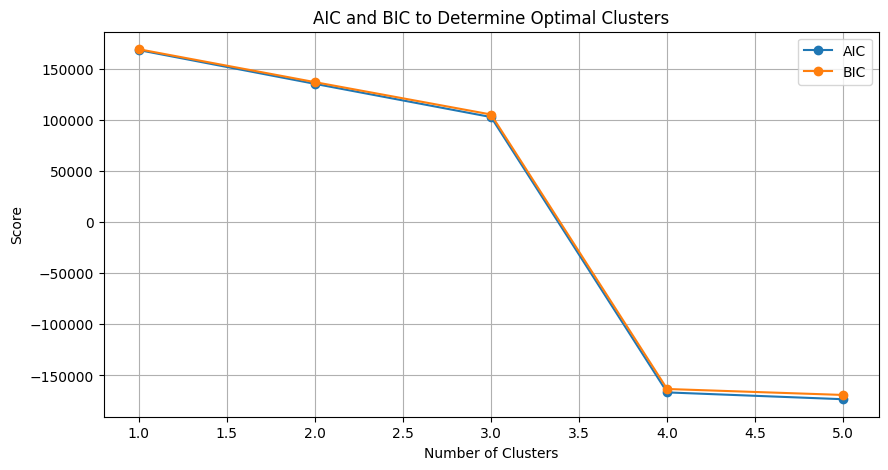

Optimal number of clusters: 5
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 0: Best model is RandomForestRegressor with CV MAE -0.22
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 1: Best model is GradientBoostingRegressor with CV MAE -1.70
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 2: Best model is Ridge with CV MAE -1.50
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 3: Best model is RandomForestRegressor with CV MAE -0.13
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 4: Best model is GradientBoostingRegressor with CV MAE -1.50
FeatureStacker - Transformer 'gmm' output shape: (860, 5)
FeatureStacker - Combined features shape: (860, 15)
FeatureStacker - Transformer 'gmm' output shape: (860, 5)
FeatureStacker - Combined features shape: (860, 15)

Tuned Evaluation Results:
 {'MSE': 0.029286589196228063, 'RMSE': np.float64(0.17113324982664258), 'MAE': 0.08808039039366083, 'R^2': 0.9291483917080219, 'Name': 'Tuned Clustered Pipeline', 'MSE_GBP': 75971.82820415734, 'RMSE_GBP': np.float64(275.6298753839238), 'MAE_GBP': 122.06321061610161, 'y_pred': array([6.60617103, 6.79764987, 6.25575004, 6.7876498 , 6.61661512,
       6.96069725, 7.48352273, 6.79794041, 7.62739657, 6.84559716,
       7.16125928, 6.79050981, 7.43035447, 6.97998089, 7.5581845 ,
       7.25042521, 6.25

c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [10]:
# Use only the top 10 features
X = claims_data[top_10_features]
# y = claims_data['SettlementValue']
y = np.log1p(claims_data['SettlementValue'])  # Log transformation

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with ClusterModelTrainerWithTuning
pipeline_tuned = create_full_pipeline(
    X=X_train,
    max_clusters=5,
    trainer_class=ClusterModelTrainerWithTuning
)

# Fit the pipeline
pipeline_tuned.fit(X_train, y_train)

# Predict and evaluate
y_pred_tuned = pipeline_tuned.predict(X_test)

results_tuned = evaluate_model(pipeline_tuned, X_test, y_test, model_name="Tuned Clustered Pipeline", log_transform=True)
print("\nTuned Evaluation Results:\n", results_tuned)

In [11]:
def plot_cluster_model_performance(cluster_performance):
    cluster_ids = list(cluster_performance.keys())
    mae_scores = [cluster_performance[c]['cv_mae'] for c in cluster_ids]
    sizes = [cluster_performance[c]['size'] for c in cluster_ids]

    plt.figure(figsize=(8,6))
    bars = plt.bar(cluster_ids, mae_scores, color='skyblue')
    for bar, size in zip(bars, sizes):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f"n={size}", ha='center', va='bottom')

    plt.xlabel("Cluster ID")
    plt.ylabel("Cross-Validated MAE")
    plt.title("Per-Cluster Model Performance with Sizes")
    plt.xticks(cluster_ids)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

def plot_predictions_vs_actual(y_true, y_pred):
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label='Ideal Prediction')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Final Predictions vs. Actual")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

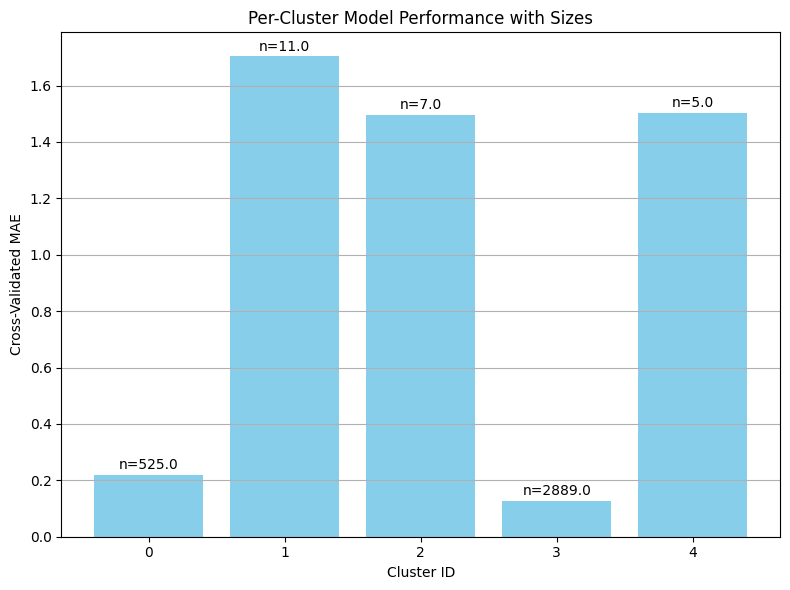

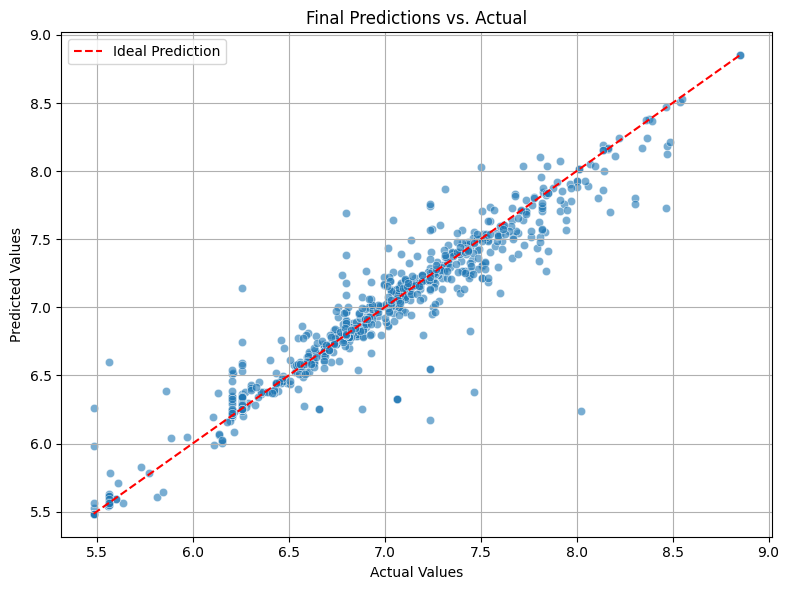

In [12]:
plot_cluster_model_performance(pipeline_tuned.named_steps['cluster_model_trainer'].cluster_performance)

plot_predictions_vs_actual(y_test, y_pred)

### Tune max_clusters to get best results


Categorical columns: []
Numerical columns: ['InjuryPrognosis', 'GeneralRest', 'SpecialTherapy', 'SpecialEarningsLoss', 'SpecialAssetDamage', 'GeneralFixed', 'SpecialLoanerVehicle', 'SpecialJourneyExpenses', 'SpecialUsageLoss', 'DaysBetweenAccidentAndClaim']
Target column: SettlementValue
FeatureStacker - Transformer 'gmm' output shape: (3437, 2)
FeatureStacker - Combined features shape: (3437, 12)


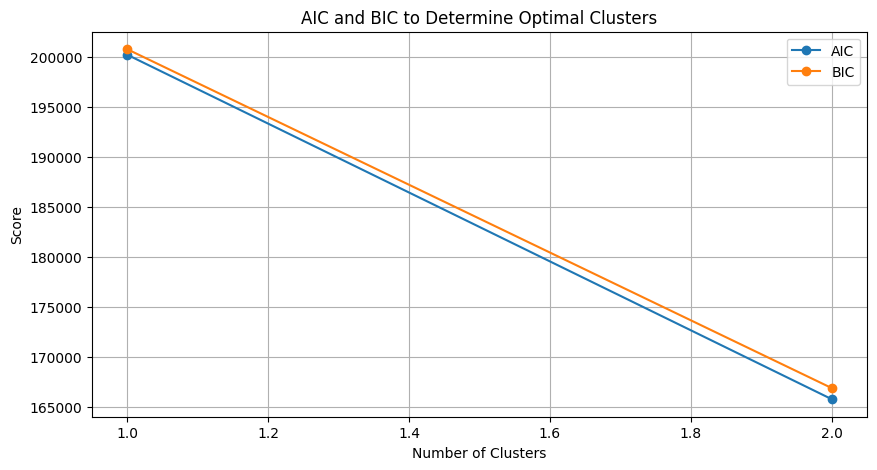

Optimal number of clusters: 2
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 0: Best model is RandomForestRegressor with CV MAE -0.10
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 1: Best model is GradientBoostingRegressor with CV MAE -1.71
FeatureStacker - Transformer 'gmm' output shape: (860, 2)
FeatureStacker - Combined features shape: (860, 12)

Categorical columns: []
Numerical columns: ['InjuryPrognosis', 'GeneralRest', 'SpecialTherapy', 'SpecialEarningsLoss', 'SpecialAssetDamage', 'GeneralFixed', 'SpecialLoanerVehicle', 'SpecialJourneyExpenses', 'SpecialUsageLoss', 'DaysBetwe

c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


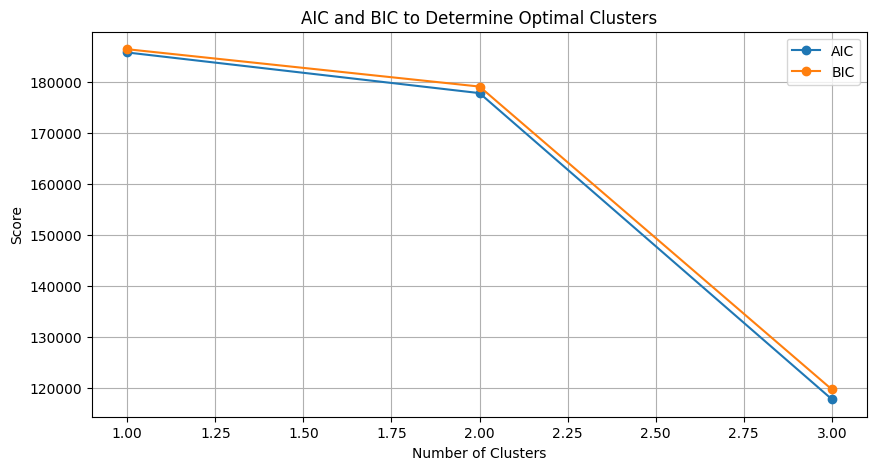

Optimal number of clusters: 3
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 0: Best model is RandomForestRegressor with CV MAE -0.10
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 1: Best model is GradientBoostingRegressor with CV MAE -1.70
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 2: Best model is Ridge with CV MAE -1.50
FeatureStacker - Transformer 'gmm' output shape: (860, 3)
FeatureStacker - Combined features shape: (860, 13)

Categorical columns: []
Numerical columns: ['InjuryPrognosis', 'GeneralRest', 'SpecialTherapy', 'SpecialEarningsLoss', 'SpecialAssetDamage', 'GeneralFixed', 'SpecialLoanerVehicle', 'SpecialJourneyExpenses', 'SpecialUsageLoss', 'DaysBetweenAccidentAndClaim']
Target column: SettlementValue


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


FeatureStacker - Transformer 'gmm' output shape: (3437, 4)
FeatureStacker - Combined features shape: (3437, 14)


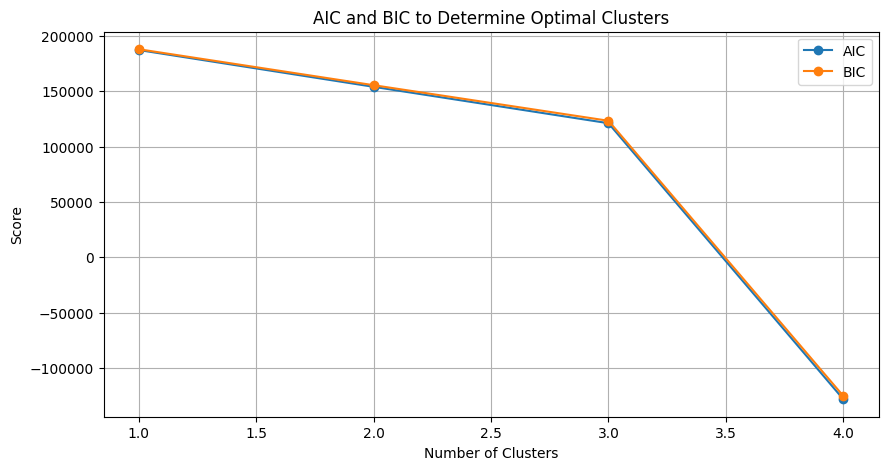

Optimal number of clusters: 4
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 0: Best model is RandomForestRegressor with CV MAE -0.22
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 1: Best model is GradientBoostingRegressor with CV MAE -1.71
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 2: Best model is Ridge with CV MAE -1.50
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 3: Best model is RandomForestRegressor with CV MAE -0.13
FeatureStacker - Transformer 'gmm' output shape: (860, 4)
FeatureStacker - Combined features shape: (860, 14)

Categorical columns: []
Numerical columns: ['InjuryPrognosis', 'GeneralRest', 'SpecialTherapy', 'SpecialEarningsLoss', 'SpecialAssetDamage', 'GeneralFixed', 'SpecialLoanerVehicle', 'SpecialJourneyExpenses', 'SpecialUsageLoss', 'DaysBetweenAccidentAndClaim']
Target column: SettlementValue
FeatureStacker - Transformer 'gmm' output shape: (3437, 5)


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


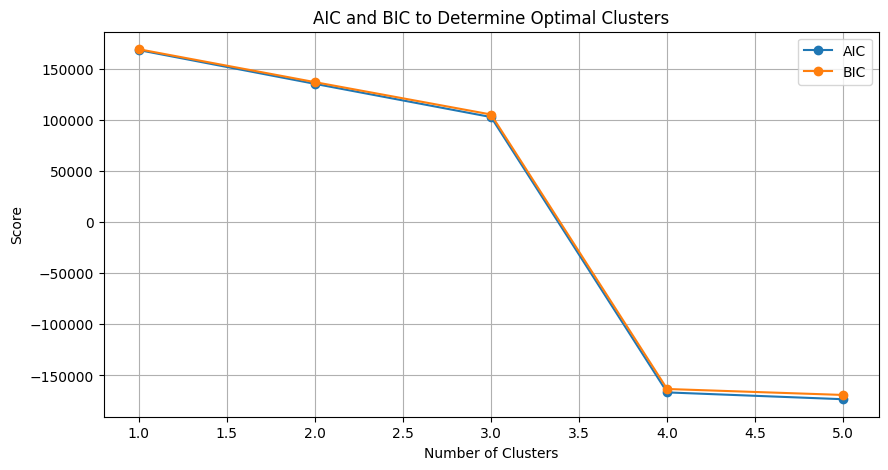

Optimal number of clusters: 5
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 0: Best model is RandomForestRegressor with CV MAE -0.22
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 1: Best model is GradientBoostingRegressor with CV MAE -1.70
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 2: Best model is Ridge with CV MAE -1.50
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 3: Best model is RandomForestRegressor with CV MAE -0.13
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 4: Best model is GradientBoostingRegressor with CV MAE -1.50
FeatureStacker - Transformer 'gmm' output shape: (860, 5)
FeatureStacker - Combined features shape: (860, 15)

Categorical columns: []
Numerical columns: ['InjuryPrognosis', 'GeneralRest', 'SpecialTherapy', 'SpecialEarningsLoss', 'SpecialAssetDamage', 'GeneralFixed', 'SpecialLoanerVehicle', 'SpecialJourneyExpenses', 'SpecialUsageLoss', 'DaysBetweenAccidentAndClaim']
Target column: SettlementValue


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


FeatureStacker - Transformer 'gmm' output shape: (3437, 6)
FeatureStacker - Combined features shape: (3437, 16)


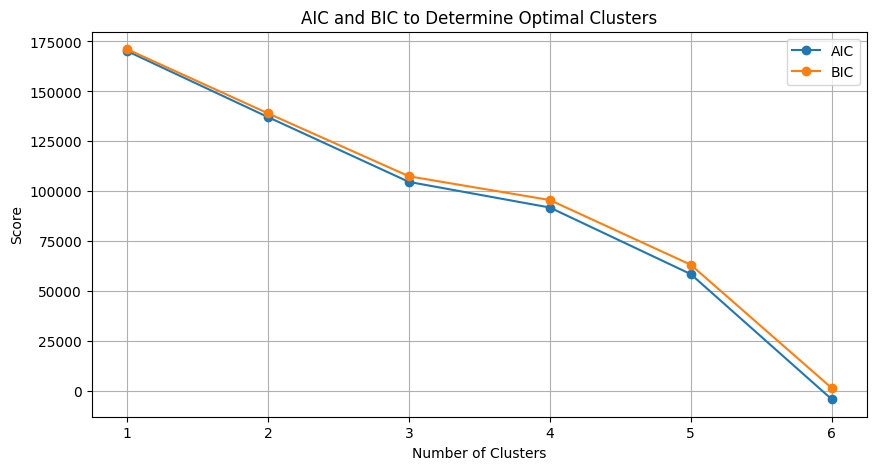

Optimal number of clusters: 6
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 0: Best model is RandomForestRegressor with CV MAE -0.14
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 1: Best model is GradientBoostingRegressor with CV MAE -1.68
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 2: Best model is Ridge with CV MAE -1.50
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 3: Best model is Ridge with CV MAE -0.30
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 4: Best model is GradientBoostingRegressor with CV MAE -1.49
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 5: Best model is GradientBoostingRegressor with CV MAE -0.28
FeatureStacker - Transformer 'gmm' output shape: (860, 6)
FeatureStacker - Combined features shape: (860, 16)

Categorical columns: []
Numerical columns: ['InjuryPrognosis', 'GeneralRest', 'SpecialTherapy', 'SpecialEarningsLoss', 'SpecialAssetDamage', 'GeneralFixed', 'SpecialLoanerVehicle', 'SpecialJourneyExpenses', 'SpecialUsageLoss', 'DaysBetweenAccidentAndClaim']
Target column: SettlementValue


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


FeatureStacker - Transformer 'gmm' output shape: (3437, 6)
FeatureStacker - Combined features shape: (3437, 16)


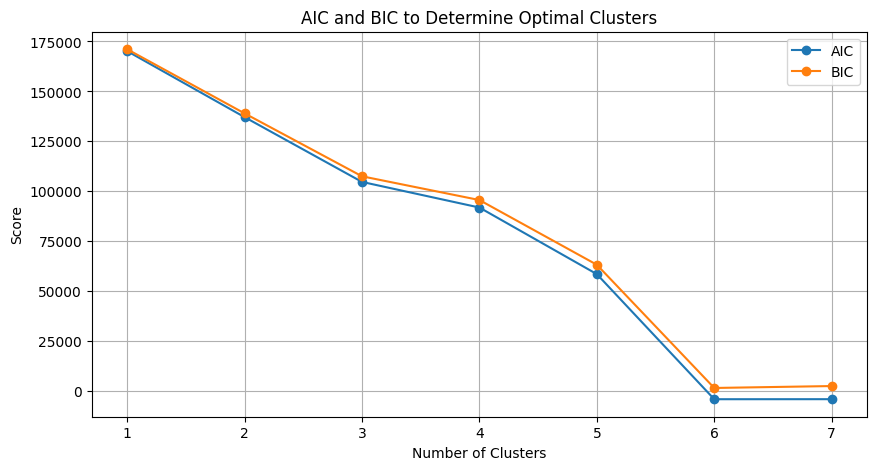

Optimal number of clusters: 6
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 0: Best model is RandomForestRegressor with CV MAE -0.14
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 1: Best model is GradientBoostingRegressor with CV MAE -1.68
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 2: Best model is Ridge with CV MAE -1.50
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 3: Best model is Ridge with CV MAE -0.30
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 4: Best model is GradientBoostingRegressor with CV MAE -1.49
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 5: Best model is GradientBoostingRegressor with CV MAE -0.28
FeatureStacker - Transformer 'gmm' output shape: (860, 6)
FeatureStacker - Combined features shape: (860, 16)

Categorical columns: []
Numerical columns: ['InjuryPrognosis', 'GeneralRest', 'SpecialTherapy', 'SpecialEarningsLoss', 'SpecialAssetDamage', 'GeneralFixed', 'SpecialLoanerVehicle', 'SpecialJourneyExpenses', 'SpecialUsageLoss', 'DaysBetweenAccidentAndClaim']
Target column: SettlementValue


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


FeatureStacker - Transformer 'gmm' output shape: (3437, 6)
FeatureStacker - Combined features shape: (3437, 16)


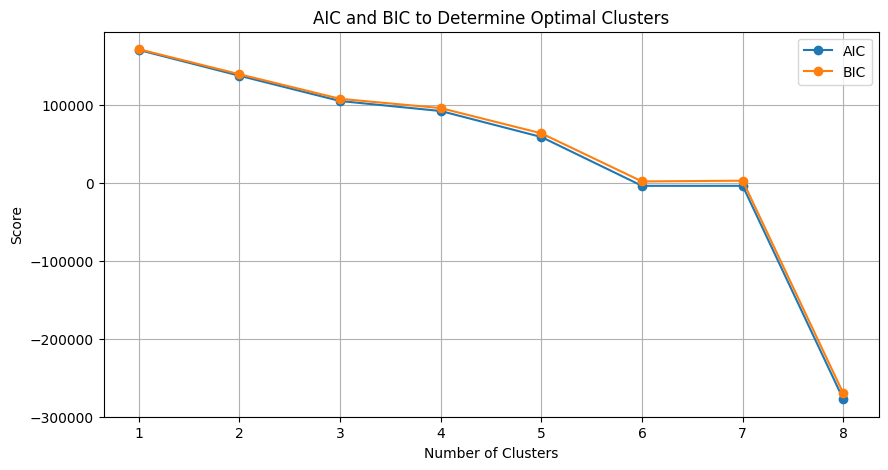

Optimal number of clusters: 8
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 0: Best model is Ridge with CV MAE -0.30
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 1: Best model is LinearRegression with CV MAE -1.51
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 2: Best model is Ridge with CV MAE -1.50
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 3: Best model is Ridge with CV MAE -0.25
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 4: Best model is Ridge with CV MAE -0.25
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 5: Best model is GradientBoostingRegressor with CV MAE -1.49
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 6: Best model is Ridge with CV MAE -0.30
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 7: Best model is GradientBoostingRegressor with CV MAE -1.24
FeatureStacker - Transformer 'gmm' output shape: (860, 6)
FeatureStacker - Combined features shape: (860, 16)


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(



Categorical columns: []
Numerical columns: ['InjuryPrognosis', 'GeneralRest', 'SpecialTherapy', 'SpecialEarningsLoss', 'SpecialAssetDamage', 'GeneralFixed', 'SpecialLoanerVehicle', 'SpecialJourneyExpenses', 'SpecialUsageLoss', 'DaysBetweenAccidentAndClaim']
Target column: SettlementValue
FeatureStacker - Transformer 'gmm' output shape: (3437, 9)
FeatureStacker - Combined features shape: (3437, 19)


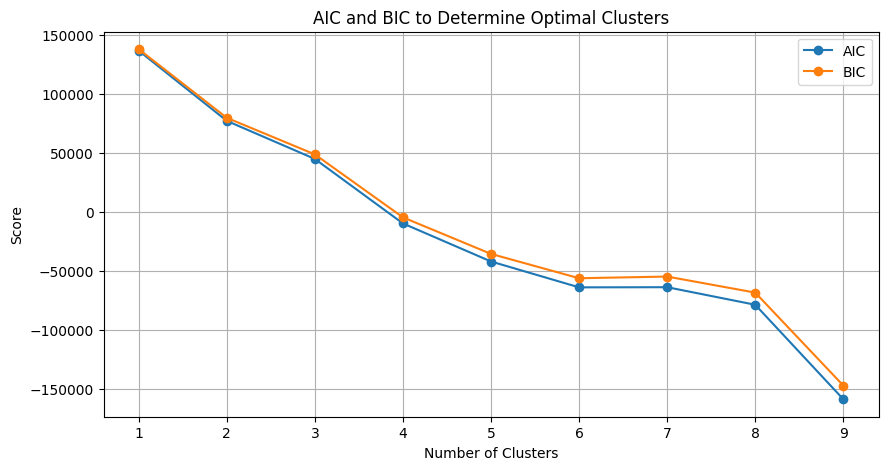

Optimal number of clusters: 9
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 0: Best model is RandomForestRegressor with CV MAE -0.14
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 1: Best model is LinearRegression with CV MAE -1.51
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 2: Best model is Ridge with CV MAE -1.50
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 3: Best model is GradientBoostingRegressor with CV MAE -0.29
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 4: Best model is RandomForestRegressor with CV MAE -0.36
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 5: Best model is GradientBoostingRegressor with CV MAE -1.51
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 6: Best model is Ridge with CV MAE -0.45
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 7: Best model is GradientBoostingRegressor with CV MAE -1.16
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 8: Best model is Ridge with CV MAE -0.30
FeatureStacker - Transformer 'gmm' output shape: (860, 9)
FeatureStacker - Combined features shape: (860, 19)

Categorical columns: []
Numerical columns: ['InjuryPrognosis', 'GeneralRest', 'SpecialTherapy', 'SpecialEarningsLoss', 'SpecialAssetDamage', 'GeneralFixed', 'SpecialLoanerVehicle', 'SpecialJourneyExpenses', 'SpecialUsageLoss', 'DaysBetweenAccidentAndClaim']
Target column: SettlementValue


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


FeatureStacker - Transformer 'gmm' output shape: (3437, 9)
FeatureStacker - Combined features shape: (3437, 19)


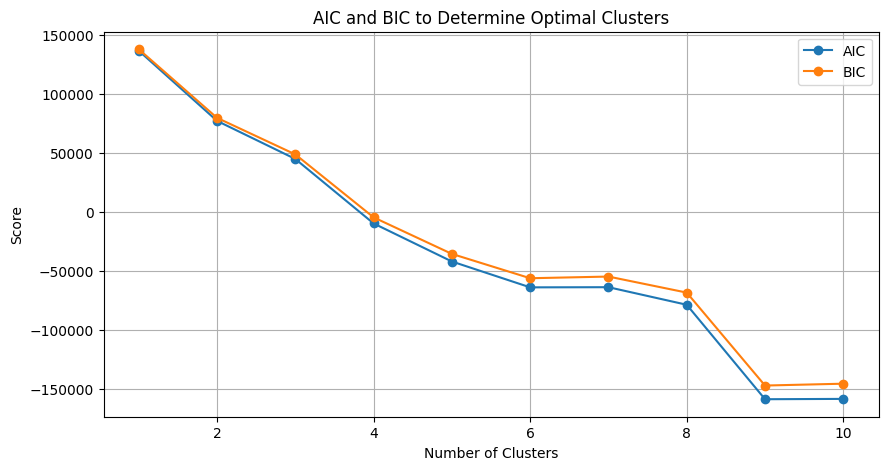

Optimal number of clusters: 9
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 0: Best model is RandomForestRegressor with CV MAE -0.14
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 1: Best model is LinearRegression with CV MAE -1.51
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 2: Best model is Ridge with CV MAE -1.50
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 3: Best model is GradientBoostingRegressor with CV MAE -0.29
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 4: Best model is RandomForestRegressor with CV MAE -0.36
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 5: Best model is GradientBoostingRegressor with CV MAE -1.51
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 6: Best model is Ridge with CV MAE -0.45
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 7: Best model is GradientBoostingRegressor with CV MAE -1.16
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 8: Best model is Ridge with CV MAE -0.30
FeatureStacker - Transformer 'gmm' output shape: (860, 9)
FeatureStacker - Combined features shape: (860, 19)

Categorical columns: []
Numerical columns: ['InjuryPrognosis', 'GeneralRest', 'SpecialTherapy', 'SpecialEarningsLoss', 'SpecialAssetDamage', 'GeneralFixed', 'SpecialLoanerVehicle', 'SpecialJourneyExpenses', 'SpecialUsageLoss', 'DaysBetweenAccidentAndClaim']
Target column: SettlementValue


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


FeatureStacker - Transformer 'gmm' output shape: (3437, 11)
FeatureStacker - Combined features shape: (3437, 21)


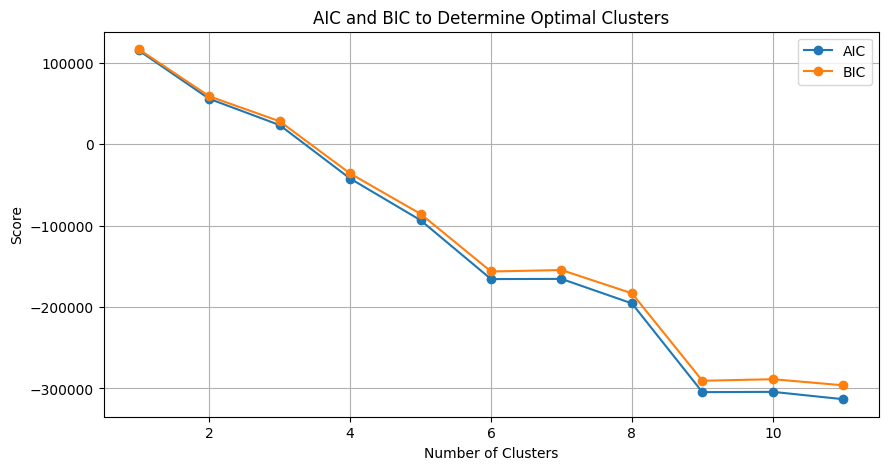

Optimal number of clusters: 11
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 0: Best model is RandomForestRegressor with CV MAE -0.15
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 1: Best model is LinearRegression with CV MAE -1.51
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 2: Best model is Ridge with CV MAE -1.50
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 3: Best model is RandomForestRegressor with CV MAE -0.43
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 4: Best model is RandomForestRegressor with CV MAE -0.26
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 5: Best model is GradientBoostingRegressor with CV MAE -1.57
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 6: Best model is Ridge with CV MAE -0.28
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 7: Best model is GradientBoostingRegressor with CV MAE -1.07
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 8: Best model is RandomForestRegressor with CV MAE -0.30
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
1 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users

No valid model found for cluster 9.
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 10: Best model is RandomForestRegressor with CV MAE -0.32
FeatureStacker - Transformer 'gmm' output shape: (860, 11)
FeatureStacker - Combined features shape: (860, 21)

Categorical columns: []
Numerical columns: ['InjuryPrognosis', 'GeneralRest', 'SpecialTherapy', 'SpecialEarningsLoss', 'SpecialAssetDamage', 'GeneralFixed', 'SpecialLoanerVehicle', 'SpecialJourneyExpenses', 'SpecialUsageLoss', 'DaysBetweenAccidentAndClaim']
Target column: SettlementValue


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


FeatureStacker - Transformer 'gmm' output shape: (3437, 12)
FeatureStacker - Combined features shape: (3437, 22)


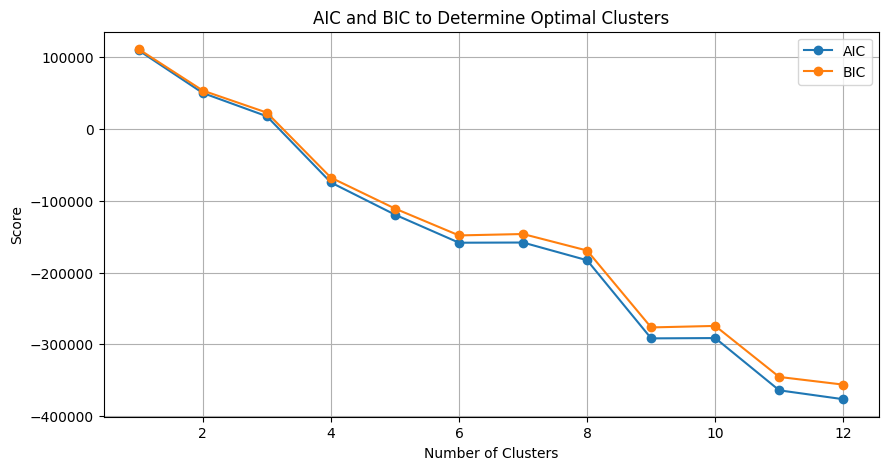

Optimal number of clusters: 12
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 0: Best model is RandomForestRegressor with CV MAE -0.15
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 1: Best model is LinearRegression with CV MAE -1.51
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 2: Best model is Ridge with CV MAE -1.50
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 3: Best model is Ridge with CV MAE -0.43
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 4: Best model is Ridge with CV MAE -0.26
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 5: Best model is GradientBoostingRegressor with CV MAE -1.57
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 6: Best model is Ridge with CV MAE -0.24
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 7: Best model is GradientBoostingRegressor with CV MAE -1.22
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 8: Best model is GradientBoostingRegressor with CV MAE -0.31
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
1 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users

No valid model found for cluster 9.
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 10: Best model is RandomForestRegressor with CV MAE -0.28
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 11: Best model is GradientBoostingRegressor with CV MAE -0.47
FeatureStacker - Transformer 'gmm' output shape: (860, 12)
FeatureStacker - Combined features shape: (860, 22)

Categorical columns: []
Numerical columns: ['InjuryPrognosis', 'GeneralRest', 'SpecialTherapy', 'SpecialEarningsLoss', 'SpecialAssetDamage', 'GeneralFixed', 'SpecialLoanerVehicle', 'SpecialJourneyExpenses', 'SpecialUsageLoss', '

c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


FeatureStacker - Transformer 'gmm' output shape: (3437, 12)
FeatureStacker - Combined features shape: (3437, 22)


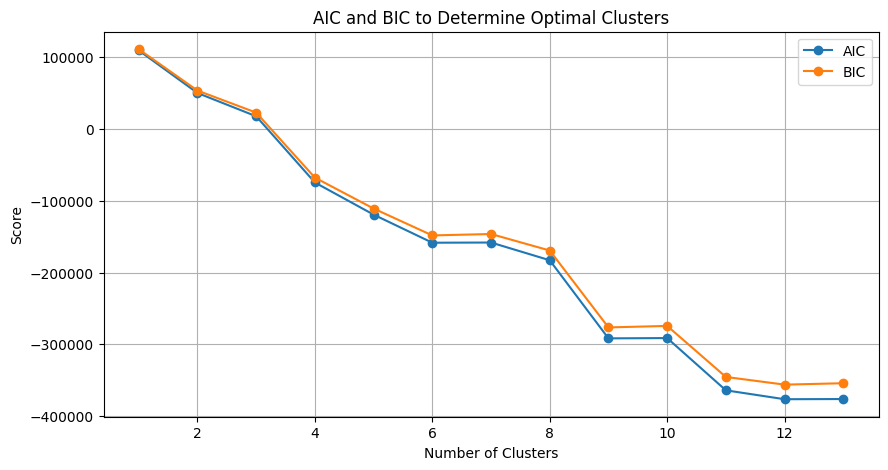

Optimal number of clusters: 12
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 0: Best model is RandomForestRegressor with CV MAE -0.15
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 1: Best model is LinearRegression with CV MAE -1.51
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 2: Best model is Ridge with CV MAE -1.50
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 3: Best model is Ridge with CV MAE -0.43
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 4: Best model is Ridge with CV MAE -0.26
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 5: Best model is GradientBoostingRegressor with CV MAE -1.57
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 6: Best model is Ridge with CV MAE -0.24
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 7: Best model is GradientBoostingRegressor with CV MAE -1.22
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 8: Best model is GradientBoostingRegressor with CV MAE -0.31
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
1 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users

No valid model found for cluster 9.
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 10: Best model is RandomForestRegressor with CV MAE -0.28
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 11: Best model is GradientBoostingRegressor with CV MAE -0.47
FeatureStacker - Transformer 'gmm' output shape: (860, 12)
FeatureStacker - Combined features shape: (860, 22)

Categorical columns: []
Numerical columns: ['InjuryPrognosis', 'GeneralRest', 'SpecialTherapy', 'SpecialEarningsLoss', 'SpecialAssetDamage', 'GeneralFixed', 'SpecialLoanerVehicle', 'SpecialJourneyExpenses', 'SpecialUsageLoss', '

c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


FeatureStacker - Transformer 'gmm' output shape: (3437, 14)
FeatureStacker - Combined features shape: (3437, 24)


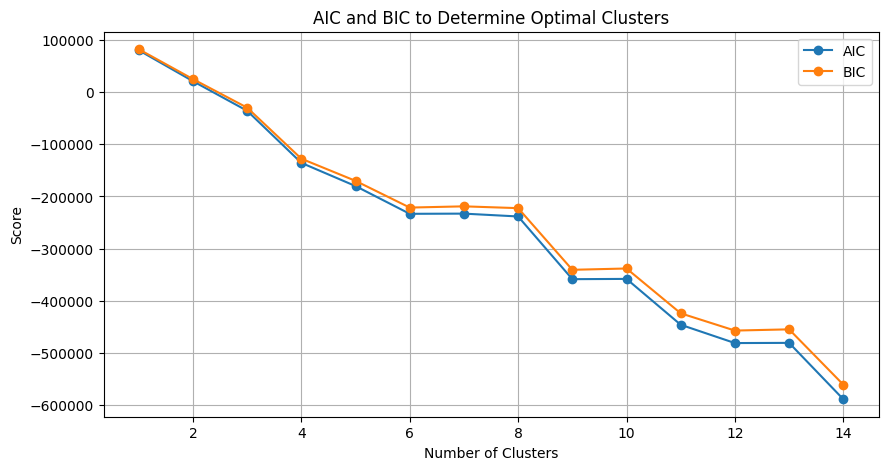

Optimal number of clusters: 14
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 0: Best model is RandomForestRegressor with CV MAE -0.19
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 1: Best model is LinearRegression with CV MAE -1.51
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 2: Best model is GradientBoostingRegressor with CV MAE -1.44
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 3: Best model is RandomForestRegressor with CV MAE -0.24
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 4: Best model is Ridge with CV MAE -0.26
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 5: Best model is GradientBoostingRegressor with CV MAE -1.57
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 6: Best model is GradientBoostingRegressor with CV MAE -0.24
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 7: Best model is GradientBoostingRegressor with CV MAE -1.26
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 8: Best model is Ridge with CV MAE -0.32
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
1 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users

No valid model found for cluster 9.
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 10: Best model is Ridge with CV MAE -0.28
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 11: Best model is GradientBoostingRegressor with CV MAE -0.41
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 12: Best model is GradientBoostingRegressor with CV MAE -1.95
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 13: Best model is Ridge with CV MAE -0.42
FeatureStacker - Transformer 'gmm' output shape: (860, 14)
FeatureStacker - Combined features shape: (860, 24)


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(



Categorical columns: []
Numerical columns: ['InjuryPrognosis', 'GeneralRest', 'SpecialTherapy', 'SpecialEarningsLoss', 'SpecialAssetDamage', 'GeneralFixed', 'SpecialLoanerVehicle', 'SpecialJourneyExpenses', 'SpecialUsageLoss', 'DaysBetweenAccidentAndClaim']
Target column: SettlementValue
FeatureStacker - Transformer 'gmm' output shape: (3437, 14)
FeatureStacker - Combined features shape: (3437, 24)


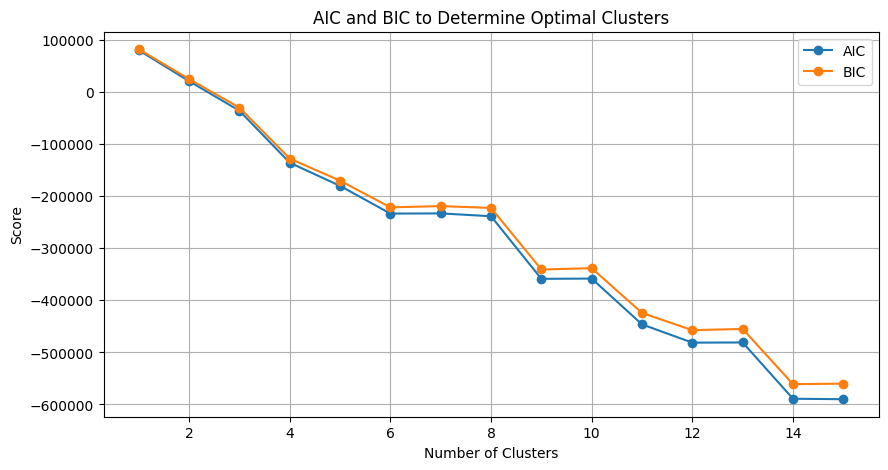

Optimal number of clusters: 14
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 0: Best model is RandomForestRegressor with CV MAE -0.19
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 1: Best model is LinearRegression with CV MAE -1.51
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 2: Best model is GradientBoostingRegressor with CV MAE -1.44
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 3: Best model is RandomForestRegressor with CV MAE -0.24
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 4: Best model is Ridge with CV MAE -0.26
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 5: Best model is GradientBoostingRegressor with CV MAE -1.57
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 6: Best model is GradientBoostingRegressor with CV MAE -0.24
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 7: Best model is GradientBoostingRegressor with CV MAE -1.26
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 8: Best model is Ridge with CV MAE -0.32
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
1 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users

No valid model found for cluster 9.
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 10: Best model is Ridge with CV MAE -0.28
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 11: Best model is GradientBoostingRegressor with CV MAE -0.41
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 12: Best model is GradientBoostingRegressor with CV MAE -1.95
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 13: Best model is Ridge with CV MAE -0.42
FeatureStacker - Transformer 'gmm' output shape: (860, 14)
FeatureStacker - Combined features shape: (860, 24)


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(



Categorical columns: []
Numerical columns: ['InjuryPrognosis', 'GeneralRest', 'SpecialTherapy', 'SpecialEarningsLoss', 'SpecialAssetDamage', 'GeneralFixed', 'SpecialLoanerVehicle', 'SpecialJourneyExpenses', 'SpecialUsageLoss', 'DaysBetweenAccidentAndClaim']
Target column: SettlementValue
FeatureStacker - Transformer 'gmm' output shape: (3437, 14)
FeatureStacker - Combined features shape: (3437, 24)


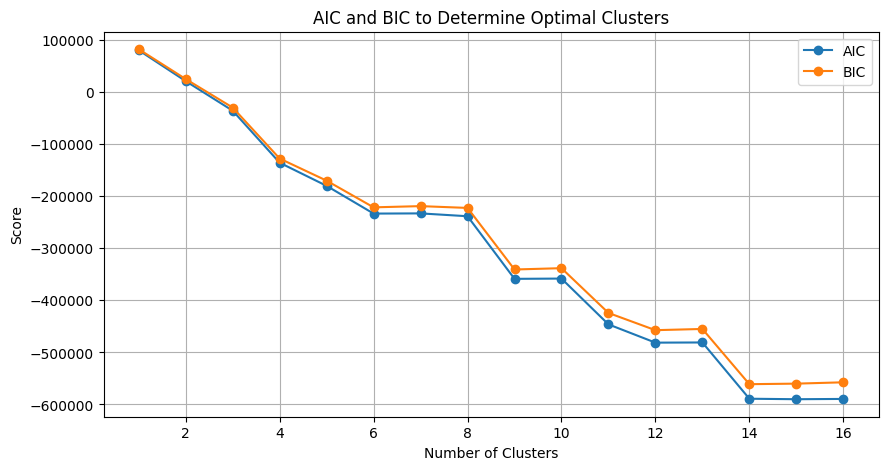

Optimal number of clusters: 14
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 0: Best model is RandomForestRegressor with CV MAE -0.19
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 1: Best model is LinearRegression with CV MAE -1.51
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 2: Best model is GradientBoostingRegressor with CV MAE -1.44
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 3: Best model is RandomForestRegressor with CV MAE -0.24
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 4: Best model is Ridge with CV MAE -0.26
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 5: Best model is GradientBoostingRegressor with CV MAE -1.57
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 6: Best model is GradientBoostingRegressor with CV MAE -0.24
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 7: Best model is GradientBoostingRegressor with CV MAE -1.26
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 8: Best model is Ridge with CV MAE -0.32
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
1 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users

No valid model found for cluster 9.
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 10: Best model is Ridge with CV MAE -0.28
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 11: Best model is GradientBoostingRegressor with CV MAE -0.41
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 12: Best model is GradientBoostingRegressor with CV MAE -1.95
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 13: Best model is Ridge with CV MAE -0.42
FeatureStacker - Transformer 'gmm' output shape: (860, 14)
FeatureStacker - Combined features shape: (860, 24)

Categorical columns: []
Numerical columns: ['InjuryPrognosis', 'GeneralRest', 'SpecialTherapy', 'SpecialEarningsLoss', 'SpecialAssetDamage', 'GeneralFixed', 'SpecialLoanerVehicle', 'SpecialJourneyExpenses', 'SpecialUsageLoss', 'DaysBetweenAccidentAndClaim']
Target column: SettlementValue


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


FeatureStacker - Transformer 'gmm' output shape: (3437, 14)
FeatureStacker - Combined features shape: (3437, 24)


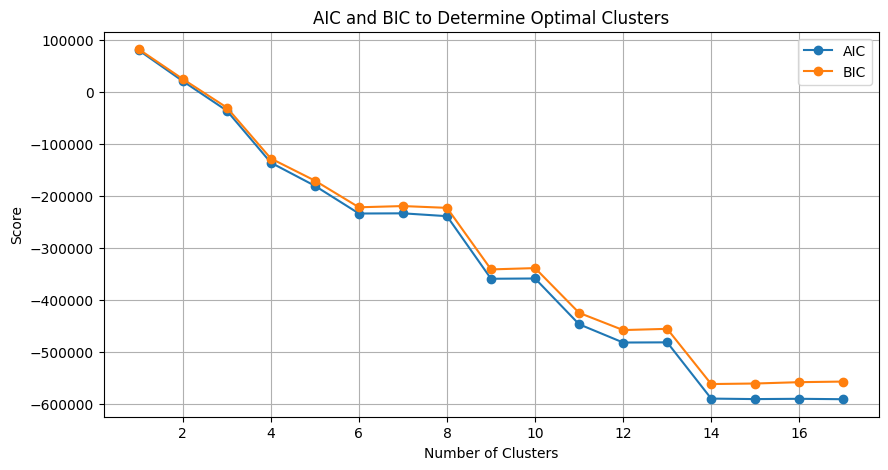

Optimal number of clusters: 14
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 0: Best model is RandomForestRegressor with CV MAE -0.19
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 1: Best model is LinearRegression with CV MAE -1.51
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 2: Best model is GradientBoostingRegressor with CV MAE -1.44
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 3: Best model is RandomForestRegressor with CV MAE -0.24
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 4: Best model is Ridge with CV MAE -0.26
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 5: Best model is GradientBoostingRegressor with CV MAE -1.57
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 6: Best model is GradientBoostingRegressor with CV MAE -0.24
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 7: Best model is GradientBoostingRegressor with CV MAE -1.26
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 8: Best model is Ridge with CV MAE -0.32
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
1 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users

No valid model found for cluster 9.
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 10: Best model is Ridge with CV MAE -0.28
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 11: Best model is GradientBoostingRegressor with CV MAE -0.41
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 12: Best model is GradientBoostingRegressor with CV MAE -1.95
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 13: Best model is Ridge with CV MAE -0.42
FeatureStacker - Transformer 'gmm' output shape: (860, 14)
FeatureStacker - Combined features shape: (860, 24)

Categorical columns: []
Numerical columns: ['InjuryPrognosis', 'GeneralRest', 'SpecialTherapy', 'SpecialEarningsLoss', 'SpecialAssetDamage', 'GeneralFixed', 'SpecialLoanerVehicle', 'SpecialJourneyExpenses', 'SpecialUsageLoss', 'DaysBetweenAccidentAndClaim']
Target column: SettlementValue


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


FeatureStacker - Transformer 'gmm' output shape: (3437, 18)
FeatureStacker - Combined features shape: (3437, 28)


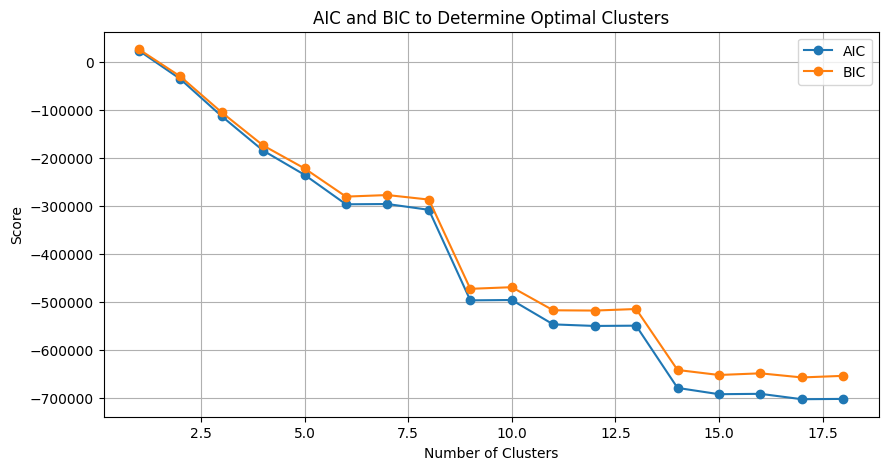

Optimal number of clusters: 17
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 0: Best model is Ridge with CV MAE -0.24
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 1: Best model is LinearRegression with CV MAE -1.51
Cluster 2 has too few weighted samples after thresholding.
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 3: Best model is GradientBoostingRegressor with CV MAE -0.61
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 4: Best model is GradientBoostingRegressor with CV MAE -0.48
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 5: Best model is GradientBoostingRegressor with CV MAE -1.57
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 6: Best model is Ridge with CV MAE -0.27
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 7: Best model is GradientBoostingRegressor with CV MAE -0.95
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 8: Best model is GradientBoostingRegressor with CV MAE -0.70
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
1 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users

No valid model found for cluster 9.
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 10: Best model is RandomForestRegressor with CV MAE -0.61
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 11: Best model is RandomForestRegressor with CV MAE -0.45
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 12: Best model is GradientBoostingRegressor with CV MAE -1.95
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 13: Best model is RandomForestRegressor with CV MAE -0.42
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 14: Best model is Ridge with CV MAE -0.30
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 15: Best model is GradientBoostingRegressor with CV MAE -1.78
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 16: Best model is Ridge with CV MAE -0.25
FeatureStacker - Transformer 'gmm' output shape: (860, 18)
FeatureStacker - Combined features shape: (860, 28)


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(



Categorical columns: []
Numerical columns: ['InjuryPrognosis', 'GeneralRest', 'SpecialTherapy', 'SpecialEarningsLoss', 'SpecialAssetDamage', 'GeneralFixed', 'SpecialLoanerVehicle', 'SpecialJourneyExpenses', 'SpecialUsageLoss', 'DaysBetweenAccidentAndClaim']
Target column: SettlementValue
FeatureStacker - Transformer 'gmm' output shape: (3437, 18)
FeatureStacker - Combined features shape: (3437, 28)


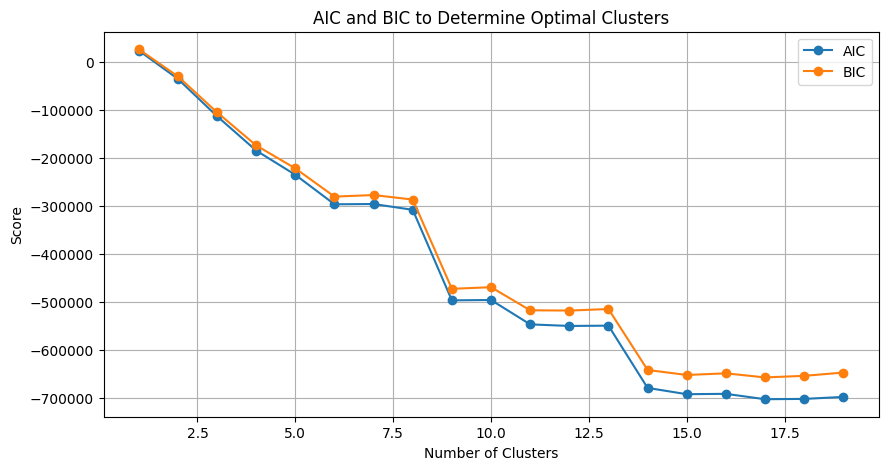

Optimal number of clusters: 17
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 0: Best model is Ridge with CV MAE -0.24
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 1: Best model is LinearRegression with CV MAE -1.51
Cluster 2 has too few weighted samples after thresholding.
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 3: Best model is GradientBoostingRegressor with CV MAE -0.61
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 4: Best model is GradientBoostingRegressor with CV MAE -0.48
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 5: Best model is GradientBoostingRegressor with CV MAE -1.57
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 6: Best model is Ridge with CV MAE -0.27
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 7: Best model is GradientBoostingRegressor with CV MAE -0.95
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 8: Best model is GradientBoostingRegressor with CV MAE -0.70
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
1 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
No valid model found for cluster 9.
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 10: Best model is RandomForestRegressor with CV MAE -0.61
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 11: Best model is RandomForestRegressor with CV MAE -0.45
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 12: Best model is GradientBoostingRegressor with CV MAE -1.95
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 13: Best model is RandomForestRegressor with CV MAE -0.42
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 14: Best model is Ridge with CV MAE -0.30
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 15: Best model is GradientBoostingRegressor with CV MAE -1.78
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 16: Best model is Ridge with CV MAE -0.25
FeatureStacker - Transformer 'gmm' output shape: (860, 18)
FeatureStacker - Combined features shape: (860, 28)


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(



Categorical columns: []
Numerical columns: ['InjuryPrognosis', 'GeneralRest', 'SpecialTherapy', 'SpecialEarningsLoss', 'SpecialAssetDamage', 'GeneralFixed', 'SpecialLoanerVehicle', 'SpecialJourneyExpenses', 'SpecialUsageLoss', 'DaysBetweenAccidentAndClaim']
Target column: SettlementValue
FeatureStacker - Transformer 'gmm' output shape: (3437, 18)
FeatureStacker - Combined features shape: (3437, 28)


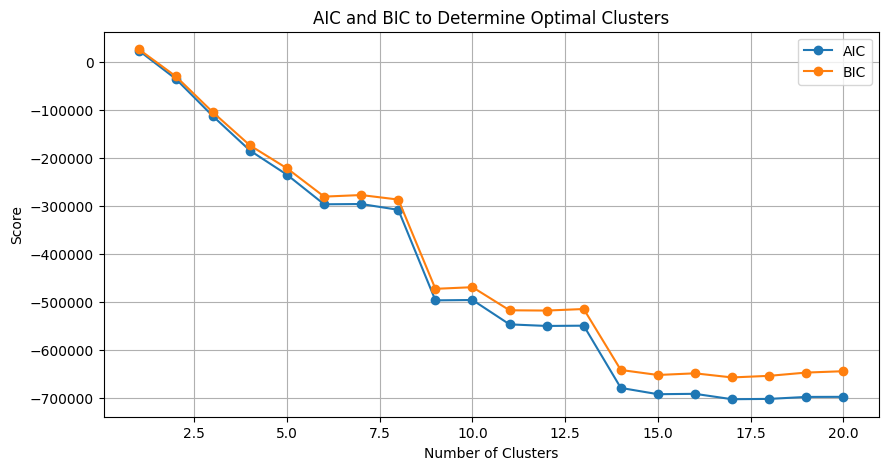

Optimal number of clusters: 17
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 0: Best model is Ridge with CV MAE -0.24
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 1: Best model is LinearRegression with CV MAE -1.51
Cluster 2 has too few weighted samples after thresholding.
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 3: Best model is GradientBoostingRegressor with CV MAE -0.61
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 4: Best model is GradientBoostingRegressor with CV MAE -0.48
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 5: Best model is GradientBoostingRegressor with CV MAE -1.57
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 6: Best model is Ridge with CV MAE -0.27
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 7: Best model is GradientBoostingRegressor with CV MAE -0.95
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 8: Best model is GradientBoostingRegressor with CV MAE -0.70
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
1 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users

No valid model found for cluster 9.
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 10: Best model is RandomForestRegressor with CV MAE -0.61
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 11: Best model is RandomForestRegressor with CV MAE -0.45
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 12: Best model is GradientBoostingRegressor with CV MAE -1.95
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 13: Best model is RandomForestRegressor with CV MAE -0.42
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 14: Best model is Ridge with CV MAE -0.30
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 15: Best model is GradientBoostingRegressor with CV MAE -1.78
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 16: Best model is Ridge with CV MAE -0.25
FeatureStacker - Transformer 'gmm' output shape: (860, 18)
FeatureStacker - Combined features shape: (860, 28)


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(



Categorical columns: []
Numerical columns: ['InjuryPrognosis', 'GeneralRest', 'SpecialTherapy', 'SpecialEarningsLoss', 'SpecialAssetDamage', 'GeneralFixed', 'SpecialLoanerVehicle', 'SpecialJourneyExpenses', 'SpecialUsageLoss', 'DaysBetweenAccidentAndClaim']
Target column: SettlementValue
FeatureStacker - Transformer 'gmm' output shape: (3437, 18)
FeatureStacker - Combined features shape: (3437, 28)


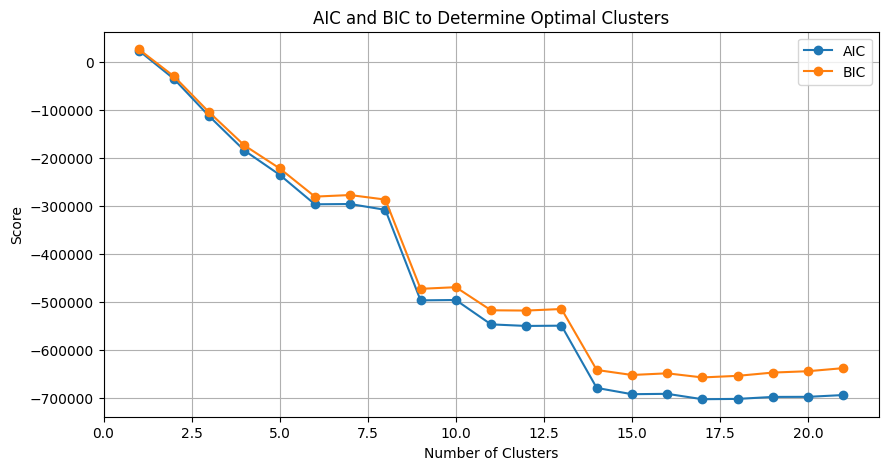

Optimal number of clusters: 17
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 0: Best model is Ridge with CV MAE -0.24
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 1: Best model is LinearRegression with CV MAE -1.51
Cluster 2 has too few weighted samples after thresholding.
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 3: Best model is GradientBoostingRegressor with CV MAE -0.61
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 4: Best model is GradientBoostingRegressor with CV MAE -0.48
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 5: Best model is GradientBoostingRegressor with CV MAE -1.57
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 6: Best model is Ridge with CV MAE -0.27
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 7: Best model is GradientBoostingRegressor with CV MAE -0.95
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 8: Best model is GradientBoostingRegressor with CV MAE -0.70
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
1 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
No valid model found for cluster 9.
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 10: Best model is RandomForestRegressor with CV MAE -0.61
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 11: Best model is RandomForestRegressor with CV MAE -0.45
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 12: Best model is GradientBoostingRegressor with CV MAE -1.95
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 13: Best model is RandomForestRegressor with CV MAE -0.42
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 14: Best model is Ridge with CV MAE -0.30
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 15: Best model is GradientBoostingRegressor with CV MAE -1.78
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 16: Best model is Ridge with CV MAE -0.25
FeatureStacker - Transformer 'gmm' output shape: (860, 18)
FeatureStacker - Combined features shape: (860, 28)


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(



Categorical columns: []
Numerical columns: ['InjuryPrognosis', 'GeneralRest', 'SpecialTherapy', 'SpecialEarningsLoss', 'SpecialAssetDamage', 'GeneralFixed', 'SpecialLoanerVehicle', 'SpecialJourneyExpenses', 'SpecialUsageLoss', 'DaysBetweenAccidentAndClaim']
Target column: SettlementValue
FeatureStacker - Transformer 'gmm' output shape: (3437, 18)
FeatureStacker - Combined features shape: (3437, 28)


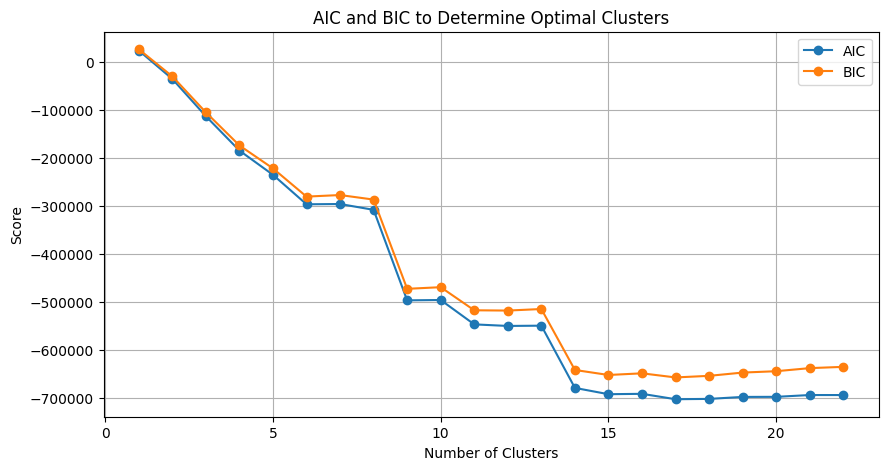

Optimal number of clusters: 17
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 0: Best model is Ridge with CV MAE -0.24
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 1: Best model is LinearRegression with CV MAE -1.51
Cluster 2 has too few weighted samples after thresholding.
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 3: Best model is GradientBoostingRegressor with CV MAE -0.61
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 4: Best model is GradientBoostingRegressor with CV MAE -0.48
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 5: Best model is GradientBoostingRegressor with CV MAE -1.57
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 6: Best model is Ridge with CV MAE -0.27
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 7: Best model is GradientBoostingRegressor with CV MAE -0.95
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 8: Best model is GradientBoostingRegressor with CV MAE -0.70
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
1 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users

No valid model found for cluster 9.
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 10: Best model is RandomForestRegressor with CV MAE -0.61
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 11: Best model is RandomForestRegressor with CV MAE -0.45
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 12: Best model is GradientBoostingRegressor with CV MAE -1.95
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 13: Best model is RandomForestRegressor with CV MAE -0.42
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 14: Best model is Ridge with CV MAE -0.30
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 15: Best model is GradientBoostingRegressor with CV MAE -1.78
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 16: Best model is Ridge with CV MAE -0.25
FeatureStacker - Transformer 'gmm' output shape: (860, 18)
FeatureStacker - Combined features shape: (860, 28)


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(



Categorical columns: []
Numerical columns: ['InjuryPrognosis', 'GeneralRest', 'SpecialTherapy', 'SpecialEarningsLoss', 'SpecialAssetDamage', 'GeneralFixed', 'SpecialLoanerVehicle', 'SpecialJourneyExpenses', 'SpecialUsageLoss', 'DaysBetweenAccidentAndClaim']
Target column: SettlementValue
FeatureStacker - Transformer 'gmm' output shape: (3437, 18)
FeatureStacker - Combined features shape: (3437, 28)


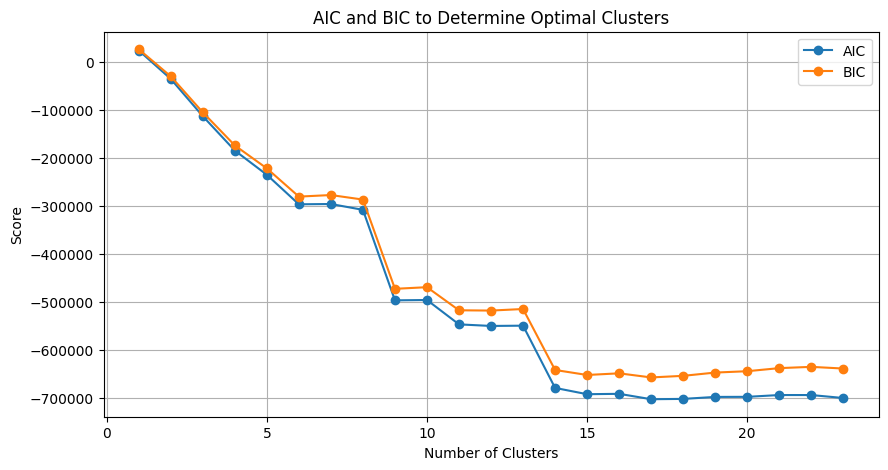

Optimal number of clusters: 17
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 0: Best model is Ridge with CV MAE -0.24
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 1: Best model is LinearRegression with CV MAE -1.51
Cluster 2 has too few weighted samples after thresholding.
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 3: Best model is GradientBoostingRegressor with CV MAE -0.61
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 4: Best model is GradientBoostingRegressor with CV MAE -0.48
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 5: Best model is GradientBoostingRegressor with CV MAE -1.57
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 6: Best model is Ridge with CV MAE -0.27
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 7: Best model is GradientBoostingRegressor with CV MAE -0.95
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 8: Best model is GradientBoostingRegressor with CV MAE -0.70
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
1 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
No valid model found for cluster 9.
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 10: Best model is RandomForestRegressor with CV MAE -0.61
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 11: Best model is RandomForestRegressor with CV MAE -0.45
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 12: Best model is GradientBoostingRegressor with CV MAE -1.95
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 13: Best model is RandomForestRegressor with CV MAE -0.42
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 14: Best model is Ridge with CV MAE -0.30
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 15: Best model is GradientBoostingRegressor with CV MAE -1.78
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 16: Best model is Ridge with CV MAE -0.25
FeatureStacker - Transformer 'gmm' output shape: (860, 18)
FeatureStacker - Combined features shape: (860, 28)


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(



Categorical columns: []
Numerical columns: ['InjuryPrognosis', 'GeneralRest', 'SpecialTherapy', 'SpecialEarningsLoss', 'SpecialAssetDamage', 'GeneralFixed', 'SpecialLoanerVehicle', 'SpecialJourneyExpenses', 'SpecialUsageLoss', 'DaysBetweenAccidentAndClaim']
Target column: SettlementValue
FeatureStacker - Transformer 'gmm' output shape: (3437, 18)
FeatureStacker - Combined features shape: (3437, 28)


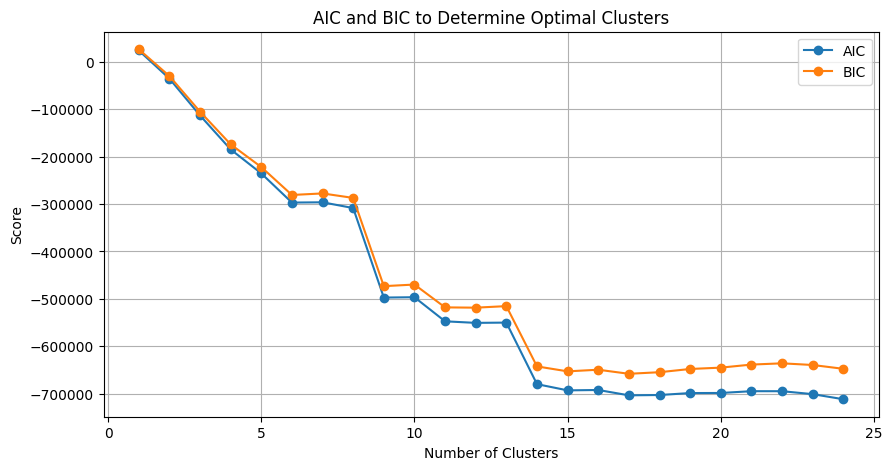

Optimal number of clusters: 17
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 0: Best model is Ridge with CV MAE -0.24
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 1: Best model is LinearRegression with CV MAE -1.51
Cluster 2 has too few weighted samples after thresholding.
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 3: Best model is GradientBoostingRegressor with CV MAE -0.61
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 4: Best model is GradientBoostingRegressor with CV MAE -0.48
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 5: Best model is GradientBoostingRegressor with CV MAE -1.57
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 6: Best model is Ridge with CV MAE -0.27
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 7: Best model is GradientBoostingRegressor with CV MAE -0.95
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 8: Best model is GradientBoostingRegressor with CV MAE -0.70
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
1 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users

Fitting 10 folds for each of 5 candidates, totalling 50 fits
No valid model found for cluster 9.
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 10: Best model is RandomForestRegressor with CV MAE -0.61
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 11: Best model is RandomForestRegressor with CV MAE -0.45
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 12: Best model is GradientBoostingRegressor with CV MAE -1.95
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 13: Best model is RandomForestRegressor with CV MAE -0.42
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 14: Best model is Ridge with CV MAE -0.30
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 15: Best model is GradientBoostingRegressor with CV MAE -1.78
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 16: Best model is Ridge with CV MAE -0.25
FeatureStacker - Transformer 'gmm' output shape: (860, 18)
FeatureStacker - Combined features shape: (860, 28)


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(



Categorical columns: []
Numerical columns: ['InjuryPrognosis', 'GeneralRest', 'SpecialTherapy', 'SpecialEarningsLoss', 'SpecialAssetDamage', 'GeneralFixed', 'SpecialLoanerVehicle', 'SpecialJourneyExpenses', 'SpecialUsageLoss', 'DaysBetweenAccidentAndClaim']
Target column: SettlementValue
FeatureStacker - Transformer 'gmm' output shape: (3437, 18)
FeatureStacker - Combined features shape: (3437, 28)


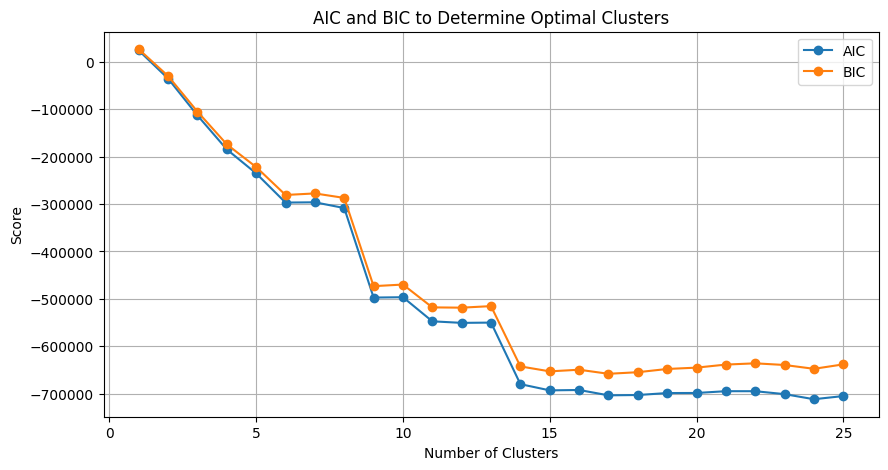

Optimal number of clusters: 17
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 0: Best model is Ridge with CV MAE -0.24
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 1: Best model is LinearRegression with CV MAE -1.51
Cluster 2 has too few weighted samples after thresholding.
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 3: Best model is GradientBoostingRegressor with CV MAE -0.61
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 4: Best model is GradientBoostingRegressor with CV MAE -0.48
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 5: Best model is GradientBoostingRegressor with CV MAE -1.57
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 6: Best model is Ridge with CV MAE -0.27
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 7: Best model is GradientBoostingRegressor with CV MAE -0.95
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 8: Best model is GradientBoostingRegressor with CV MAE -0.70
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
1 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users

No valid model found for cluster 9.
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 10: Best model is RandomForestRegressor with CV MAE -0.61
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 11: Best model is RandomForestRegressor with CV MAE -0.45
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 12: Best model is GradientBoostingRegressor with CV MAE -1.95
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 13: Best model is RandomForestRegressor with CV MAE -0.42
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 14: Best model is Ridge with CV MAE -0.30
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 15: Best model is GradientBoostingRegressor with CV MAE -1.78
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 16: Best model is Ridge with CV MAE -0.25
FeatureStacker - Transformer 'gmm' output shape: (860, 18)
FeatureStacker - Combined features shape: (860, 28)


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(



Categorical columns: []
Numerical columns: ['InjuryPrognosis', 'GeneralRest', 'SpecialTherapy', 'SpecialEarningsLoss', 'SpecialAssetDamage', 'GeneralFixed', 'SpecialLoanerVehicle', 'SpecialJourneyExpenses', 'SpecialUsageLoss', 'DaysBetweenAccidentAndClaim']
Target column: SettlementValue
FeatureStacker - Transformer 'gmm' output shape: (3437, 18)
FeatureStacker - Combined features shape: (3437, 28)


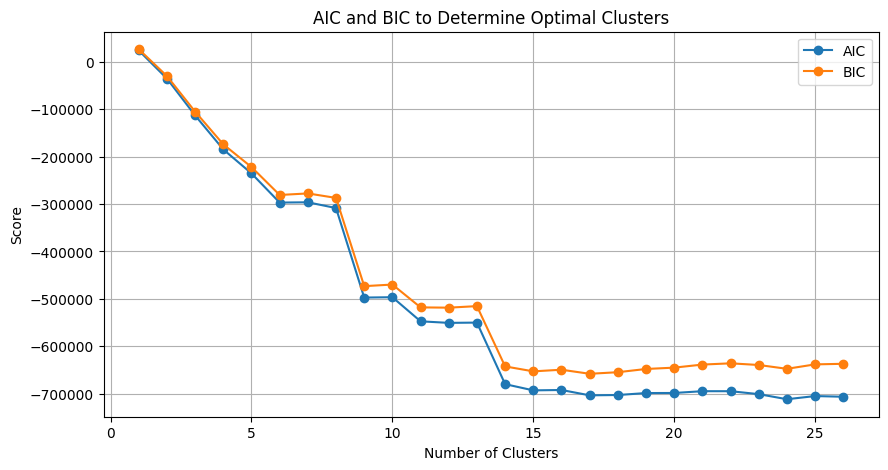

Optimal number of clusters: 17
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 0: Best model is Ridge with CV MAE -0.24
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 1: Best model is LinearRegression with CV MAE -1.51
Cluster 2 has too few weighted samples after thresholding.
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 3: Best model is GradientBoostingRegressor with CV MAE -0.61
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 4: Best model is GradientBoostingRegressor with CV MAE -0.48
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 5: Best model is GradientBoostingRegressor with CV MAE -1.57
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 6: Best model is Ridge with CV MAE -0.27
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 7: Best model is GradientBoostingRegressor with CV MAE -0.95
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 8: Best model is GradientBoostingRegressor with CV MAE -0.70
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
1 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users

No valid model found for cluster 9.
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 10: Best model is RandomForestRegressor with CV MAE -0.61
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 11: Best model is RandomForestRegressor with CV MAE -0.45
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 12: Best model is GradientBoostingRegressor with CV MAE -1.95
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 13: Best model is RandomForestRegressor with CV MAE -0.42
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 14: Best model is Ridge with CV MAE -0.30
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 15: Best model is GradientBoostingRegressor with CV MAE -1.78
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 16: Best model is Ridge with CV MAE -0.25
FeatureStacker - Transformer 'gmm' output shape: (860, 18)
FeatureStacker - Combined features shape: (860, 28)


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(



Categorical columns: []
Numerical columns: ['InjuryPrognosis', 'GeneralRest', 'SpecialTherapy', 'SpecialEarningsLoss', 'SpecialAssetDamage', 'GeneralFixed', 'SpecialLoanerVehicle', 'SpecialJourneyExpenses', 'SpecialUsageLoss', 'DaysBetweenAccidentAndClaim']
Target column: SettlementValue
FeatureStacker - Transformer 'gmm' output shape: (3437, 18)
FeatureStacker - Combined features shape: (3437, 28)


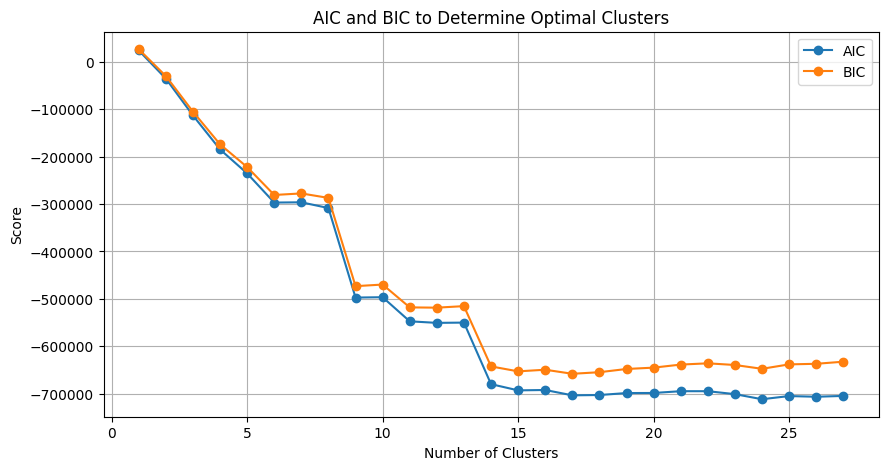

Optimal number of clusters: 17
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 0: Best model is Ridge with CV MAE -0.24
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 1: Best model is LinearRegression with CV MAE -1.51
Cluster 2 has too few weighted samples after thresholding.
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 3: Best model is GradientBoostingRegressor with CV MAE -0.61
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 4: Best model is GradientBoostingRegressor with CV MAE -0.48
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 5: Best model is GradientBoostingRegressor with CV MAE -1.57
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 6: Best model is Ridge with CV MAE -0.27
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 7: Best model is GradientBoostingRegressor with CV MAE -0.95
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 8: Best model is GradientBoostingRegressor with CV MAE -0.70
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
1 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
No valid model found for cluster 9.
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 10: Best model is RandomForestRegressor with CV MAE -0.61
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 11: Best model is RandomForestRegressor with CV MAE -0.45
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 12: Best model is GradientBoostingRegressor with CV MAE -1.95
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 13: Best model is RandomForestRegressor with CV MAE -0.42
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 14: Best model is Ridge with CV MAE -0.30
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 15: Best model is GradientBoostingRegressor with CV MAE -1.78
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 16: Best model is Ridge with CV MAE -0.25
FeatureStacker - Transformer 'gmm' output shape: (860, 18)
FeatureStacker - Combined features shape: (860, 28)

Categorical columns: []
Numerical columns: ['InjuryPrognosis', 'GeneralRest', 'SpecialTherapy', 'SpecialEarningsLoss', 'SpecialAssetDamage', 'GeneralFixed', 'SpecialLoanerVehicle', 'SpecialJourneyExpenses', 'SpecialUsageLoss', 'DaysBetweenAccidentAndClaim']
Target column: SettlementValue


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


FeatureStacker - Transformer 'gmm' output shape: (3437, 18)
FeatureStacker - Combined features shape: (3437, 28)


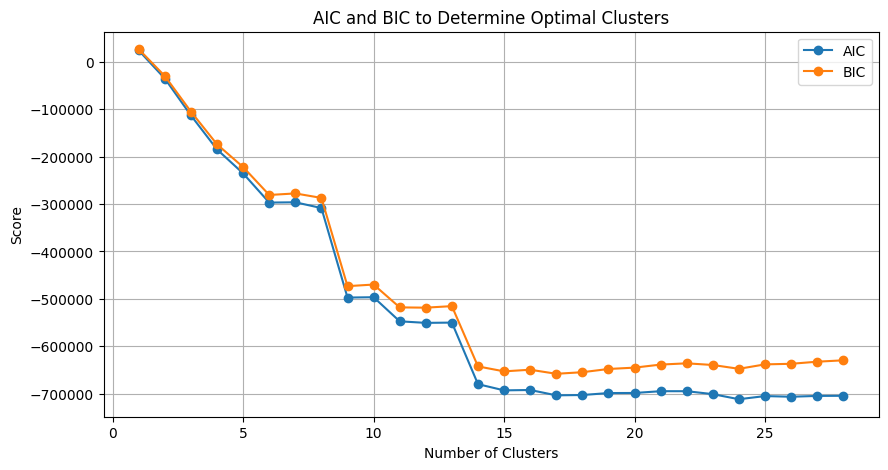

Optimal number of clusters: 17
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 0: Best model is Ridge with CV MAE -0.24
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 1: Best model is LinearRegression with CV MAE -1.51
Cluster 2 has too few weighted samples after thresholding.
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 3: Best model is GradientBoostingRegressor with CV MAE -0.61
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 4: Best model is GradientBoostingRegressor with CV MAE -0.48
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 5: Best model is GradientBoostingRegressor with CV MAE -1.57
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 6: Best model is Ridge with CV MAE -0.27
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 7: Best model is GradientBoostingRegressor with CV MAE -0.95
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 8: Best model is GradientBoostingRegressor with CV MAE -0.70
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
1 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users

No valid model found for cluster 9.
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 10: Best model is RandomForestRegressor with CV MAE -0.61
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 11: Best model is RandomForestRegressor with CV MAE -0.45
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 12: Best model is GradientBoostingRegressor with CV MAE -1.95
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 13: Best model is RandomForestRegressor with CV MAE -0.42
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 14: Best model is Ridge with CV MAE -0.30
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 15: Best model is GradientBoostingRegressor with CV MAE -1.78
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 16: Best model is Ridge with CV MAE -0.25
FeatureStacker - Transformer 'gmm' output shape: (860, 18)
FeatureStacker - Combined features shape: (860, 28)


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(



Categorical columns: []
Numerical columns: ['InjuryPrognosis', 'GeneralRest', 'SpecialTherapy', 'SpecialEarningsLoss', 'SpecialAssetDamage', 'GeneralFixed', 'SpecialLoanerVehicle', 'SpecialJourneyExpenses', 'SpecialUsageLoss', 'DaysBetweenAccidentAndClaim']
Target column: SettlementValue
FeatureStacker - Transformer 'gmm' output shape: (3437, 18)
FeatureStacker - Combined features shape: (3437, 28)


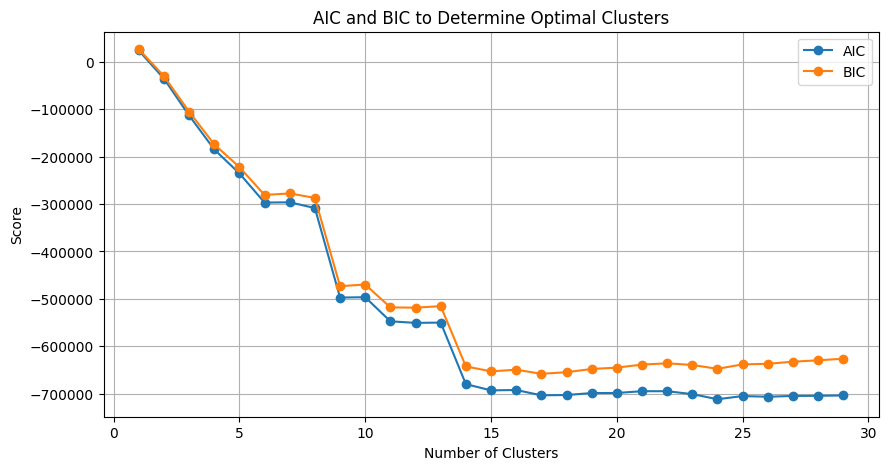

Optimal number of clusters: 17
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 0: Best model is Ridge with CV MAE -0.24
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 1: Best model is LinearRegression with CV MAE -1.51
Cluster 2 has too few weighted samples after thresholding.
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 3: Best model is GradientBoostingRegressor with CV MAE -0.61
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 4: Best model is GradientBoostingRegressor with CV MAE -0.48
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 5: Best model is GradientBoostingRegressor with CV MAE -1.57
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 6: Best model is Ridge with CV MAE -0.27
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 7: Best model is GradientBoostingRegressor with CV MAE -0.95
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 8: Best model is GradientBoostingRegressor with CV MAE -0.70
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
1 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users

No valid model found for cluster 9.
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 10: Best model is RandomForestRegressor with CV MAE -0.61
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 11: Best model is RandomForestRegressor with CV MAE -0.45
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 12: Best model is GradientBoostingRegressor with CV MAE -1.95
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 13: Best model is RandomForestRegressor with CV MAE -0.42
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 14: Best model is Ridge with CV MAE -0.30
Fitting 10 folds for each of 1 candidates, totalling 10 fits


c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 15: Best model is GradientBoostingRegressor with CV MAE -1.78
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Cluster 16: Best model is Ridge with CV MAE -0.25
FeatureStacker - Transformer 'gmm' output shape: (860, 18)
FeatureStacker - Combined features shape: (860, 28)
Best max_clusters: 3
Best score: {'MSE': 0.0275207110099833, 'RMSE': np.float64(0.1658936738094111), 'MAE': 0.08297564987420322, 'R^2': 0.9334204941609521, 'Name': 'Pipeline with 3 Clusters', 'MSE_GBP': 63908.31262119313, 'RMSE_GBP': np.float64(252.8009347712012), 'MAE_GBP': 114.89961393543192, 'y_pred': array([6.53037312, 6.7903958 , 6.259

c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [13]:
# Define the range of max_clusters to test
max_clusters_range = range(2, 30)  # Testing values from 2 to 10

best_score = {
    'RMSE_GBP': np.inf,
    'MAE_GBP': np.inf,
}
best_max_clusters = None
best_pipeline = None

# Iterate through each value of max_clusters
for max_clusters in max_clusters_range:
    # Create a pipeline with the current max_clusters
    pipeline = create_full_pipeline(
        X=X_train,
        max_clusters=max_clusters,
        trainer_class=ClusterModelTrainerWithTuning
    )
    
    # Fit the pipeline
    pipeline.fit(X_train, y_train)
    
    # Evaluate the pipeline
    results = evaluate_model(pipeline, X_test, y_test, model_name=f"Pipeline with {max_clusters} Clusters", log_transform=True)
    
    # Check if this is the best score
    # 'MSE': mse,
    # 'RMSE': rmse,
    # 'MAE': mae,
    # 'R^2': r2,
    if results['RMSE_GBP'] < best_score['RMSE_GBP'] and results['MAE_GBP'] < best_score['MAE_GBP']:  # Replace 'score' with the appropriate metric key
        best_score = results
        best_max_clusters = max_clusters
        best_pipeline = pipeline

# Print the best max_clusters and its performance
print(f"Best max_clusters: {best_max_clusters}")
print(f"Best score: {best_score}")

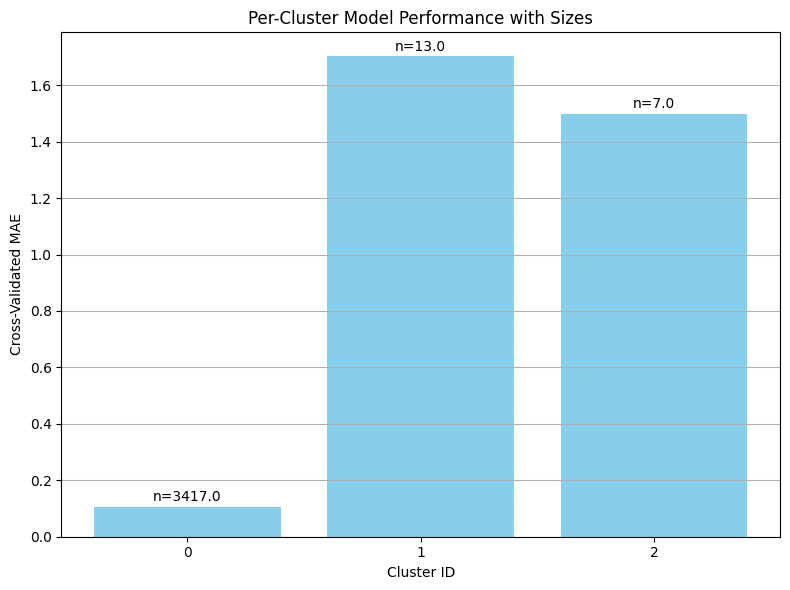

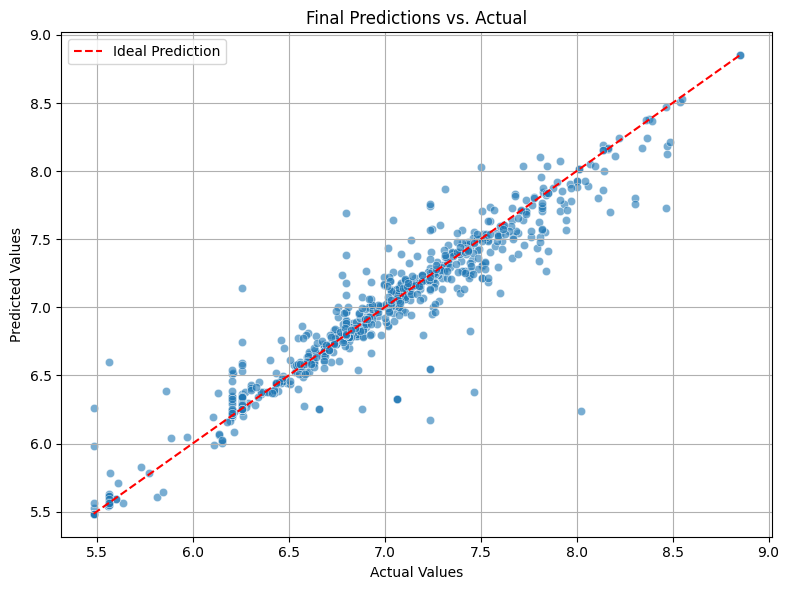

In [14]:
plot_cluster_model_performance(best_pipeline.named_steps['cluster_model_trainer'].cluster_performance)

plot_predictions_vs_actual(y_test, y_pred)

### Compare the three pipelines, original, trained hyper-parameters and trained m_clusters

In [16]:
def compare_pipelines(pipeline, pipeline_tuned, best_pipeline, X_test, y_test):
    """
    Compares the performance of different pipelines on the test set.

    Args:
        pipeline: Original pipeline.
        pipeline_tuned: Tuned pipeline.
        best_pipeline: Best performing pipeline.
        X_test: Test features.
        y_test: Test target.
    """
    results_pipeline = evaluate_model(pipeline, X_test, y_test, model_name="Pipeline", log_transform=True)
    results_pipeline_tuned = evaluate_model(pipeline_tuned, X_test, y_test, model_name="Tuned Pipeline", log_transform=True)
    results_best_pipeline = evaluate_model(best_pipeline, X_test, y_test, model_name="Best Pipeline", log_transform=True)

    print ("\nComparison of Pipelines:")
    print("Original Pipeline")
    print(f"RMSE: {results_pipeline['RMSE']}, R^2: {results_pipeline['R^2']}")
    print(f"Error in GBP - RMSE : £{results_pipeline['RMSE_GBP']}, MAE: £{results_pipeline['MAE_GBP']}")
    print("----------------------")
    print("Tuned Pipeline")
    print(f"RMSE: {results_pipeline_tuned['RMSE']}, R^2: {results_pipeline_tuned['R^2']}")
    print(f"Error in GBP - RMSE : £{results_pipeline_tuned['RMSE_GBP']}, MAE: £{results_pipeline_tuned['MAE_GBP']}")
    print("----------------------")
    print("Best Pipeline")
    print(f"RMSE: {results_best_pipeline['RMSE']}, R^2: {results_best_pipeline['R^2']}")
    print(f"Error in GBP - RMSE : £{results_best_pipeline['RMSE_GBP']}, MAE: £{results_best_pipeline['MAE_GBP']}")
    print("----------------------")

    # Save the best model based on lowest RMSE, highest R^2, lowest RMSE_GBP, and lowest MAE_GBP
    best_model = results_pipeline
    best_score = {
        'RMSE': results_pipeline['RMSE'],
        'R^2': results_pipeline['R^2'],
        'RMSE_GBP': results_pipeline['RMSE_GBP'],
        'MAE_GBP': results_pipeline['MAE_GBP']
    }

    if results_pipeline_tuned['RMSE'] < best_score['RMSE'] and results_pipeline_tuned['R^2'] > best_score['R^2'] and results_pipeline_tuned['RMSE_GBP'] < best_score['RMSE_GBP'] and results_pipeline_tuned['MAE_GBP'] < best_score['MAE_GBP']:
        best_model = results_pipeline_tuned
        best_score['RMSE'] = results_pipeline_tuned['RMSE']
        best_score['R^2'] = results_pipeline_tuned['R^2']
        best_score['RMSE_GBP'] = results_pipeline_tuned['RMSE_GBP']
        best_score['MAE_GBP'] = results_pipeline_tuned['MAE_GBP']

    if results_best_pipeline['RMSE'] < best_score['RMSE'] and results_best_pipeline['R^2'] > best_score['R^2'] and results_best_pipeline['RMSE_GBP'] < best_score['RMSE_GBP'] and results_best_pipeline['MAE_GBP'] < best_score['MAE_GBP']:
        best_model = results_best_pipeline
        best_score['RMSE'] = results_best_pipeline['RMSE']
        best_score['R^2'] = results_best_pipeline['R^2']
        best_score['RMSE_GBP'] = results_best_pipeline['RMSE_GBP']
        best_score['MAE_GBP'] = results_best_pipeline['MAE_GBP']

    return best_model

best_model = compare_pipelines(
    pipeline,
    pipeline_tuned,
    best_pipeline,
    X_test,
    y_test
)

print("\nBest Model:")
print(best_model)

FeatureStacker - Transformer 'gmm' output shape: (860, 18)
FeatureStacker - Combined features shape: (860, 28)
FeatureStacker - Transformer 'gmm' output shape: (860, 5)
FeatureStacker - Combined features shape: (860, 15)
FeatureStacker - Transformer 'gmm' output shape: (860, 3)
FeatureStacker - Combined features shape: (860, 13)

Comparison of Pipelines:
Original Pipeline
RMSE: 0.4220052196829854, R^2: 0.569159458651449
Error in GBP - RMSE : £1755.1643871651368, MAE: £334.35233179633263
----------------------
Tuned Pipeline
RMSE: 0.17113324982664258, R^2: 0.9291483917080219
Error in GBP - RMSE : £275.6298753839238, MAE: £122.06321061610161
----------------------
Best Pipeline
RMSE: 0.1658936738094111, R^2: 0.9334204941609521
Error in GBP - RMSE : £252.8009347712012, MAE: £114.89961393543192
----------------------

Best Model:
{'MSE': 0.0275207110099833, 'RMSE': np.float64(0.1658936738094111), 'MAE': 0.08297564987420322, 'R^2': 0.9334204941609521, 'Name': 'Best Pipeline', 'MSE_GBP': 639

c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\claytonc\Desktop\Uni-Year-3\headlights-main\aai-ml\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  w

### Save best pipeline as model

In [17]:
filename = 'soft_clustering.pkl'

with open(filename, 'wb') as file:
    pickle.dump(best_model, file)